In [16]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as functional
import torch.nn.init as init

In [17]:
class SimpleCNN(nn.Module):

    def __init__(self, width_multiplier: int, use_batchnorm=False):
        super(SimpleCNN, self).__init__()
        self.width_multiplier = width_multiplier
        self.use_batchnorm = use_batchnorm
        
        self.conv1 = nn.Conv2d(1, 2 * width_multiplier, 5, padding=2)
        self.conv2 = nn.Conv2d(2 * width_multiplier, 4 * width_multiplier, 5, padding=2)
        self.linear: nn.Linear = nn.Linear(4 * width_multiplier * 7 * 7, 64 * width_multiplier)
        self.output = nn.Linear(64 * width_multiplier, 10)
        
        def initialize_weights(module: nn.Module):
            if module != self:
                init.normal(module.weight.data, mean=0.0, std=0.1)
        
        self.apply(initialize_weights)
    
    def forward(self, x: autograd.Variable) -> autograd.Variable:
        y = functional.max_pool2d(functional.relu(self.conv1(x)), 2)
        y = functional.max_pool2d(functional.relu(self.conv2(y)), 2)
        y = functional.relu(self.linear(y.view(-1, 4*self.width_multiplier*7*7)))
        y = self.output(y)
        return y


# Now, we test the network to see if it works. 
net = SimpleCNN(1)
print(net(autograd.Variable(torch.rand((2, 1, 28, 28)))))

Variable containing:
 0.0215 -0.0058  0.0024 -0.0781 -0.1698 -0.0053 -0.1340 -0.1609 -0.0307  0.0480
 0.0033  0.0037 -0.0039 -0.1002 -0.1902  0.0116 -0.1326 -0.1512 -0.0260  0.0471
[torch.FloatTensor of size 2x10]



In [18]:
import typing
import numpy.testing as testing


def fsgm(image_batch: torch.FloatTensor,
         label_batch: torch.LongTensor,
         model: typing.Callable[[autograd.Variable], autograd.Variable],
         objective: typing.Callable[[autograd.Variable, autograd.Variable], autograd.Variable],
         eps: float):
    """Takes a batch of images, and modifies each image using the FGSM attack."""
    for i in range(image_batch.shape[0]):
        x = autograd.Variable(torch.unsqueeze(image_batch[i], 0), requires_grad=True)
        label = autograd.Variable(label_batch[i:i+1])
        output: autograd.Variable = model(x)
        loss: autograd.Variable = objective(output, label)
        loss.backward()
        x.data += eps*torch.sign(x.grad.data)
        torch.clamp(x.data, min=0.0, max=1.0, out=x.data)


# Now, we test to see there are no obvious errors. 
def test_fsgm():
    net = SimpleCNN(1)
    image = torch.zeros((1, 1, 28, 28)) + 0.5
    label = torch.LongTensor([2])
    perturbed_image = image.clone()
    fsgm(perturbed_image, label, net, nn.CrossEntropyLoss(), 0.3)
    perturbation = torch.abs(perturbed_image - image)
    testing.assert_almost_equal(
            perturbation.numpy(),
            ((perturbation > 0).float()*0.3).numpy(),
            15)


def test_fsgm_no_errors_on_cuda():
    net = SimpleCNN(1)
    net.cuda()
    image: torch.FloatTensor = (torch.zeros((1, 1, 28, 28)) + 0.5).cuda()
    label = torch.LongTensor([2]).cuda()
    perturbed_image: torch.FloatTensor = image.clone()
    assert perturbed_image.is_cuda
    fsgm(perturbed_image, label, net, nn.CrossEntropyLoss(), 0.3)


for i in range(10):
    test_fsgm()
test_fsgm_no_errors_on_cuda()

# What did we learn from this test? How to handle possible zero-gradients. Also, when doing random
# initializations, test a few times to make sure that nothing can go wrong with tests. 

In [19]:
def pgd(image_batch: torch.FloatTensor,
        label_batch: torch.LongTensor,
        model: typing.Callable[[autograd.Variable], autograd.Variable],
        objective: typing.Callable[[autograd.Variable, autograd.Variable], autograd.Variable],
        eps: float,
        alpha: float,
        num_steps: int,
        num_restarts: int):
    """Runs PGD on the negative of the given loss function with the given parameters on the given image."""
    
    def pgd_without_restarts(sample_index: int):
        """PGD on negative of the loss function. This has no random restarts."""
        image = image_batch[sample_index]
        x_min = torch.clamp(image - eps, min=0.0)
        x_max = torch.clamp(image + eps, max=1.0)
        random_perturbation = torch.rand(image.shape)*eps
        if image_batch.is_cuda:
            random_perturbation = random_perturbation.cuda()
        random_start = torch.clamp(image + random_perturbation, min=0.0, max=1.0)
        x = autograd.Variable(torch.unsqueeze(random_start, 0), requires_grad=True)
        for i in range(num_steps):
            output = model(x)
            label = autograd.Variable(label_batch[sample_index:sample_index + 1])
            loss = objective(output, label)
            loss.backward()
            x.data += alpha*torch.sign(x.grad.data)
            x.data = torch.min(torch.max(x.data, x_min), x_max)
            x.grad.data.fill_(0)
        return x.data, loss.data[0]
    
    max_loss = -float("inf")
    best_perturbed_image = None
    for i in range(image_batch.shape[0]):
        for _ in range(num_restarts):
            perturbed_image, loss = pgd_without_restarts(i)
            if loss > max_loss:
                max_loss = loss
                best_perturbed_image = perturbed_image
        image_batch[i] = best_perturbed_image


def test_no_runtime_errors():
    net: SimpleCNN = SimpleCNN(1)
    image: torch.FloatTensor = torch.rand((2, 1, 28, 28))
    label: torch.LongTensor = torch.LongTensor([2, 2])
    net.zero_grad()
    pgd(image, label, net, nn.CrossEntropyLoss(), 0.3, 0.6, 4, 2)


def test_no_runtime_errors_on_cuda():
    net: SimpleCNN = SimpleCNN(1)
    net.cuda()
    image: torch.FloatTensor = torch.rand((2, 1, 28, 28)).cuda()
    label: torch.LongTensor = torch.LongTensor([2, 2]).cuda()
    net.zero_grad()
    pgd(image, label, net, nn.CrossEntropyLoss(), 0.3, 0.6, 4, 2)


# A more fine-grained test. We will create a specific linear model and test that the resulting images fall within a
# certain range. 
class LinearModel(nn.Module):
    def __init__(self, label: int):
        super(LinearModel, self).__init__()
        self.linear: nn.Linear = nn.Linear(1*28*28, 10)
        self.linear.weight.data.fill_(0)
        self.linear.weight.data[label, :].fill_(1)
    
    def forward(self, x: autograd.Variable):
        y: autograd.Variable = x.view((-1, 1*28*28,))
        return y


def test_linear_model():
    lin = LinearModel(2)
    testing.assert_almost_equal(lin.linear.weight.data[0:2, :].numpy(), torch.zeros((2, 28*28)).numpy(), 15)
    testing.assert_almost_equal(lin.linear.weight.data[2, :].numpy(), torch.ones((28*28,)).numpy(), 15)
    testing.assert_almost_equal(lin.linear.weight.data[3:, :].numpy(), torch.zeros((7, 28*28)).numpy(), 15)


def dummy_loss_function(output_batch: autograd.Variable, label_batch: autograd.Variable) -> autograd.Variable:
    return -0.5*torch.sum(nn.MSELoss(reduce=False)(output_batch, autograd.Variable(torch.zeros(
        output_batch.data.shape))), dim=1)


def test_dummy_loss_function():
    identity: autograd.Variable = autograd.Variable(torch.eye(2, 10))
    expected_result: autograd.Variable = autograd.Variable(-0.5*torch.ones((2,)))
    testing.assert_equal(dummy_loss_function(identity, None).data.numpy(), expected_result.data.numpy())


def test_single_step_pgd():
    image: torch.FloatTensor = torch.zeros(2, 1, 28, 28) + 0.5
    labels: torch.LongTensor = torch.LongTensor([2, 2])
    perturbed_image: torch.FloatTensor = image.clone()
    pgd(perturbed_image, labels, LinearModel(2), dummy_loss_function, 0.3, 1.0, 1, 20)
    testing.assert_almost_equal(perturbed_image.numpy(), torch.zeros(image.shape) + 0.2)


def test_multistep_pgd():
    image: torch.FloatTensor = torch.zeros(2, 1, 28, 28) + 0.5
    labels: torch.LongTensor = torch.LongTensor([2, 2])
    perturbed_image: torch.FloatTensor = image.clone()
    pgd(perturbed_image, labels, LinearModel(2), dummy_loss_function, eps=0.3, alpha=0.01, num_restarts=1, num_steps=10)
    
    image_min: torch.FloatTensor = torch.clamp(image - 0.3, min=0.0)
    
    # Calculate image max
    image_max: torch.FloatTensor = image + 0.3
    for _ in range(10):
        image_max = image_max - 0.01*image_max
    image_max = torch.max(image_max, image_min)
    
    testing.assert_array_less(image_min, perturbed_image)
    testing.assert_array_less(perturbed_image, image_max)


test_no_runtime_errors()
test_no_runtime_errors_on_cuda()
test_dummy_loss_function()
test_linear_model()
test_single_step_pgd()
test_multistep_pgd()

In [20]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms


image_transform = transforms.Compose([
    transforms.ToTensor()])
label_transform: typing.Callable[[int], torch.LongTensor] = lambda x: torch.LongTensor([x])


# Now we need to import MNIST and transform it. 
training_dataset = datasets.MNIST("mnist", train=True, download=True, transform=image_transform, 
                                  target_transform=label_transform)
testing_dataset = datasets.MNIST("mnist", train=False, download=True, transform=image_transform,
                                 target_transform=label_transform)
print(len(training_dataset))
print(type(training_dataset[0][0]))
print(type(training_dataset[0][1]))
print(len(testing_dataset))
print(type(testing_dataset[0][0]))
print(type(testing_dataset[0][1]))

60000
<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>
10000
<class 'torch.FloatTensor'>
<class 'torch.LongTensor'>


From the above code, I learned the following:
* MNIST dataset, without transforms, consists of a list of tuples; each tuple has two elements: a PIL image (28x28) and an integer label (0-9). 
* The above applies for both the training and testing set. 
* The target_transform is used to transform the label, while the transform is used to transform the image. 

Now, we need to concatenate the dataset into one large tensor so that it can be modified with the FGSM and PGD methods. 

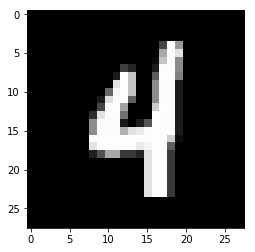

In [21]:
import random

import matplotlib.pyplot as pyplot


training_images: torch.FloatTensor = torch.zeros((len(training_dataset), 1, 28, 28)).float()
training_labels: torch.LongTensor = torch.zeros((len(training_dataset),)).long()
testing_images: torch.FloatTensor = torch.zeros((len(training_dataset), 1, 28, 28)).float()
testing_labels: torch.LongTensor = torch.zeros((len(training_dataset),)).long()

for index, (image, label) in enumerate(training_dataset):
    training_images[index] = torch.unsqueeze(image, 0)
    training_labels[index:index + 1] = label

for index, (image, label) in enumerate(testing_dataset):
    testing_images[index] = torch.unsqueeze(image, 0)
    testing_labels[index:index + 1] = label

pyplot.imshow(training_images[random.randint(0, len(training_images) - 1)].squeeze().numpy(), cmap='gray')

With our images and labels as the proper datatypes (FloatTensor size Nx1x28x28 and LongTensor size N, respectively), we can now run FGSM and PGD on each batch. Due to torch's easy semantics for dealing with CUDA, all we need to do is put everything on the GPU and run our experiment. 

In [23]:
import functools
import time


# Let's generate figure 4!

training_images = training_images.cuda()
training_labels = training_labels.cuda()
testing_images = testing_images.cuda()
testing_labels = testing_labels.cuda()


def natural(*args, **kwargs):
    pass


def train_simple_cnn(training_attack: str, testing_attack: str, capacity_scale: int,
                     batches_between_outputs=10) -> [float, float]:
    """
    Trains an instance of SimpleCNN with the given capcity scale on training images, which were perturbed via 
    training_attack, and then tests the resulting model on testing images, which were perturbed via testing_attack.
    Note that perturbations on the training images are recomputed for each batch, since the attacks depend on the
    state of the current model instance. The accuracy (and loss) of the model on the test images is returned. 
    
    This method is used to generate a single point on one of the plots in the top half of Figure 4. 
    
    :param training_attack: One of {'natural', 'fgsm', 'pgd'}.
    :param testing_attack: One of {'natural', 'fgsm', 'pgd'},
    :param capacity_scale: One of {1, 2, 4, 8, 16}. 
    :return: The accuracy and loss of the trained model on the test set. 
    """
    net = SimpleCNN(capacity_scale)
    net.cuda()
    
    def get_attack_function(name: str) -> typing.Callable[[torch.FloatTensor, torch.LongTensor], None]:
        if name == 'natural':
            return natural
        elif name == 'fgsm':
            return functools.partial(fsgm, model=net, objective=nn.CrossEntropyLoss(), eps=0.3)
        elif name == 'pgd':
            return functools.partial(pgd, model=net, objective=nn.CrossEntropyLoss(), eps=0.3, alpha=0.01,
                                     num_steps=40, num_restarts=1)
    
    training_attack = get_attack_function(training_attack)
    testing_attack = get_attack_function(testing_attack)
    
    shuffled_indexes = torch.randperm(len(training_images)).cuda()
    shuffled_training_images = training_images[shuffled_indexes]
    shuffled_training_labels = training_labels[shuffled_indexes]
    
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    batch_start_index = 0
    batch_size = 50
    num_steps = 10000
    start_time = time.time()
    for step in range(num_steps):
        batch_images: torch.FloatTensor = torch.zeros((batch_size,) + testing_images[0, :, :, :].shape).float().cuda()
        batch_labels: torch.LongTensor = torch.zeros((batch_size,)).long().cuda()
        batch_images.copy_(shuffled_training_images[batch_start_index:batch_start_index + batch_size])
        batch_labels.copy_(shuffled_training_labels[batch_start_index:batch_start_index + batch_size])
        training_attack(batch_images, batch_labels)
        output = net(autograd.Variable(batch_images))
        loss: autograd.Variable = functional.cross_entropy(output, autograd.Variable(batch_labels))
        net.zero_grad()
        loss.backward()
        optimizer.step()
        end_time = time.time()
        if step % batches_between_outputs == 0:
            _, predictions = torch.max(output.data, 1)
            fraction_correct = float((predictions == batch_labels).sum())/batch_size
            print(
                'Step {0}: loss={1}, accuracy={2}, duration={3}'.format(
                    str(step), str(loss.data[0]), str(fraction_correct), str(end_time - start_time)))
        start_time = end_time
    
    testing_batch_size = 100  # Must divide len(testing_images).
    total_loss = 0.0
    total_correct = 0
    num_samples = 0
    for batch_index in range(int(len(testing_images)/testing_batch_size)):
        batch_images: torch.FloatTensor = torch.zeros(
            (testing_batch_size,) + testing_images[0, :, :, :].shape).float().cuda()
        batch_labels: torch.LongTensor = torch.zeros((testing_batch_size,)).long().cuda()
        batch_images.copy_(testing_images[batch_index * testing_batch_size:(batch_index + 1)*testing_batch_size])
        batch_labels.copy_(testing_labels[batch_index * testing_batch_size:(batch_index + 1)*testing_batch_size])
        testing_attack(batch_images, batch_labels)
        output: autograd.Variable = net(autograd.Variable(batch_images))
        loss: autograd.Variable = functional.cross_entropy(output, autograd.Variable(batch_labels), size_average=False)
        _, predictions = torch.max(output.data, 1)
        total_correct += (predictions == batch_labels).sum()
        total_loss += loss.data[0]
        num_samples += testing_batch_size
    
    return total_loss/num_samples, float(total_correct)/num_samples


# For our sanity check, we want to train the network on PGD and test it on FGSM; the accuracy should be about 95.6%. 
loss, accuracy = train_simple_cnn('pgd', 'fgsm', 16)
print('PGD training vs. FGSM attack: loss={0}, accuracy={1}'.format(loss, accuracy))

Step 0: loss=31.227148056030273, accuracy=0.12, duration=2.5017433166503906


Step 10: loss=22.813705444335938, accuracy=0.12, duration=2.336646318435669


Step 20: loss=16.93490982055664, accuracy=0.18, duration=2.419447183609009


Step 30: loss=14.053675651550293, accuracy=0.2, duration=2.3328168392181396


Step 40: loss=17.685012817382812, accuracy=0.12, duration=2.341299533843994


Step 50: loss=15.065049171447754, accuracy=0.06, duration=2.3708748817443848


Step 60: loss=13.53706169128418, accuracy=0.2, duration=2.3361737728118896


Step 70: loss=15.136141777038574, accuracy=0.1, duration=2.3446261882781982


Step 80: loss=14.304883003234863, accuracy=0.12, duration=2.4359397888183594


Step 90: loss=10.871712684631348, accuracy=0.18, duration=2.357456684112549


Step 100: loss=10.914905548095703, accuracy=0.24, duration=2.352492332458496


Step 110: loss=12.353723526000977, accuracy=0.14, duration=2.3427412509918213


Step 120: loss=11.796009063720703, accuracy=0.16, duration=2.350379228591919


Step 130: loss=9.763707160949707, accuracy=0.26, duration=2.358701467514038


Step 140: loss=9.82498550415039, accuracy=0.12, duration=2.342946767807007


Step 150: loss=10.630365371704102, accuracy=0.06, duration=2.350834846496582


Step 160: loss=9.072463989257812, accuracy=0.1, duration=2.34486985206604


Step 170: loss=10.0386323928833, accuracy=0.16, duration=2.3577353954315186


Step 180: loss=8.54184341430664, accuracy=0.2, duration=2.3487765789031982


Step 190: loss=8.143446922302246, accuracy=0.16, duration=2.356959819793701


Step 200: loss=8.19759750366211, accuracy=0.16, duration=2.368382453918457


Step 210: loss=7.466868877410889, accuracy=0.12, duration=2.3603243827819824


Step 220: loss=6.9565324783325195, accuracy=0.2, duration=2.3386542797088623


Step 230: loss=9.801939010620117, accuracy=0.06, duration=2.342252016067505


Step 240: loss=7.478801727294922, accuracy=0.12, duration=2.3470237255096436


Step 250: loss=6.3834943771362305, accuracy=0.16, duration=2.336967706680298


Step 260: loss=6.336887836456299, accuracy=0.2, duration=2.3468217849731445


Step 270: loss=7.2926812171936035, accuracy=0.1, duration=2.335184335708618


Step 280: loss=6.2540388107299805, accuracy=0.1, duration=2.3754866123199463


Step 290: loss=6.108461380004883, accuracy=0.2, duration=2.3580777645111084


Step 300: loss=6.602621078491211, accuracy=0.12, duration=2.3283567428588867


Step 310: loss=6.604391574859619, accuracy=0.14, duration=2.353369951248169


Step 320: loss=6.177921295166016, accuracy=0.16, duration=2.3464746475219727


Step 330: loss=5.8293070793151855, accuracy=0.18, duration=2.336670398712158


Step 340: loss=5.873513221740723, accuracy=0.16, duration=2.3512394428253174


Step 350: loss=6.022193431854248, accuracy=0.18, duration=2.348357677459717


Step 360: loss=3.78987455368042, accuracy=0.24, duration=2.340653896331787


Step 370: loss=5.608058452606201, accuracy=0.06, duration=2.345991849899292


Step 380: loss=4.017721176147461, accuracy=0.18, duration=2.349043130874634


Step 390: loss=4.837561130523682, accuracy=0.16, duration=2.3436005115509033


Step 400: loss=4.541721343994141, accuracy=0.2, duration=2.3398776054382324


Step 410: loss=5.273177623748779, accuracy=0.16, duration=2.3569836616516113


Step 420: loss=5.087244987487793, accuracy=0.08, duration=2.344122886657715


Step 430: loss=4.108604431152344, accuracy=0.16, duration=2.3446900844573975


Step 440: loss=3.5626039505004883, accuracy=0.18, duration=2.3495798110961914


Step 450: loss=3.9022490978240967, accuracy=0.2, duration=2.3406999111175537


Step 460: loss=3.2902214527130127, accuracy=0.24, duration=2.342780351638794


Step 470: loss=3.083198308944702, accuracy=0.26, duration=2.339139699935913


Step 480: loss=4.769588470458984, accuracy=0.16, duration=2.3392467498779297


Step 490: loss=3.6023905277252197, accuracy=0.16, duration=2.342742443084717


Step 500: loss=3.781318426132202, accuracy=0.18, duration=2.3412668704986572


Step 510: loss=3.1391260623931885, accuracy=0.26, duration=2.3361012935638428


Step 520: loss=3.1949093341827393, accuracy=0.26, duration=2.3368961811065674


Step 530: loss=3.5887157917022705, accuracy=0.14, duration=2.3371846675872803


Step 540: loss=4.785387992858887, accuracy=0.16, duration=2.3365678787231445


Step 550: loss=4.157467842102051, accuracy=0.16, duration=2.3486833572387695


Step 560: loss=3.5688207149505615, accuracy=0.26, duration=2.341629981994629


Step 570: loss=3.165416955947876, accuracy=0.24, duration=2.345320224761963


Step 580: loss=4.2824883460998535, accuracy=0.08, duration=2.340364933013916


Step 590: loss=3.198592185974121, accuracy=0.18, duration=2.334481954574585


Step 600: loss=2.797316074371338, accuracy=0.26, duration=2.339573621749878


Step 610: loss=3.409167528152466, accuracy=0.18, duration=2.3409347534179688


Step 620: loss=3.9551281929016113, accuracy=0.16, duration=2.3509318828582764


Step 630: loss=3.70784854888916, accuracy=0.16, duration=2.354458808898926


Step 640: loss=2.6562130451202393, accuracy=0.24, duration=2.333611011505127


Step 650: loss=3.0974762439727783, accuracy=0.2, duration=2.335458517074585


Step 660: loss=3.4540677070617676, accuracy=0.24, duration=2.35396146774292


Step 670: loss=3.2589077949523926, accuracy=0.2, duration=2.3540103435516357


Step 680: loss=4.0239996910095215, accuracy=0.08, duration=2.3442413806915283


Step 690: loss=3.049872636795044, accuracy=0.16, duration=2.3566129207611084


Step 700: loss=2.984907627105713, accuracy=0.22, duration=2.337207317352295


Step 710: loss=3.6931521892547607, accuracy=0.18, duration=2.345510244369507


Step 720: loss=2.6589908599853516, accuracy=0.2, duration=2.335927724838257


Step 730: loss=3.265289306640625, accuracy=0.2, duration=2.3414313793182373


Step 740: loss=3.5576322078704834, accuracy=0.14, duration=2.344318151473999


Step 750: loss=3.682039499282837, accuracy=0.16, duration=2.3393068313598633


Step 760: loss=2.8922533988952637, accuracy=0.16, duration=2.336203098297119


Step 770: loss=3.1618704795837402, accuracy=0.22, duration=2.345391035079956


Step 780: loss=3.0738701820373535, accuracy=0.22, duration=2.341374397277832


Step 790: loss=3.230602979660034, accuracy=0.18, duration=2.335841178894043


Step 800: loss=3.253371000289917, accuracy=0.24, duration=2.331014394760132


Step 810: loss=3.0330519676208496, accuracy=0.16, duration=2.336772918701172


Step 820: loss=3.6088356971740723, accuracy=0.2, duration=2.3450706005096436


Step 830: loss=3.527590274810791, accuracy=0.16, duration=2.3428359031677246


Step 840: loss=3.3574914932250977, accuracy=0.12, duration=2.354099750518799


Step 850: loss=2.8943285942077637, accuracy=0.3, duration=2.339261054992676


Step 860: loss=3.309286117553711, accuracy=0.18, duration=2.349921703338623


Step 870: loss=2.6375086307525635, accuracy=0.26, duration=2.343508720397949


Step 880: loss=3.149643659591675, accuracy=0.26, duration=2.3454294204711914


Step 890: loss=3.39138126373291, accuracy=0.22, duration=2.352663278579712


Step 900: loss=3.214509963989258, accuracy=0.18, duration=2.3326733112335205


Step 910: loss=2.7913641929626465, accuracy=0.24, duration=2.348151683807373


Step 920: loss=2.914456844329834, accuracy=0.16, duration=2.347809314727783


Step 930: loss=3.2900893688201904, accuracy=0.18, duration=2.3442394733428955


Step 940: loss=3.2077012062072754, accuracy=0.26, duration=2.3427374362945557


Step 950: loss=2.7538177967071533, accuracy=0.24, duration=2.3365330696105957


Step 960: loss=3.059168815612793, accuracy=0.22, duration=2.34712290763855


Step 970: loss=2.917367458343506, accuracy=0.16, duration=2.347524404525757


Step 980: loss=3.1980338096618652, accuracy=0.3, duration=2.3417983055114746


Step 990: loss=2.964261531829834, accuracy=0.18, duration=2.64890193939209


Step 1000: loss=2.9598472118377686, accuracy=0.26, duration=2.3346025943756104


Step 1010: loss=2.810825824737549, accuracy=0.22, duration=2.3533518314361572


Step 1020: loss=2.7936792373657227, accuracy=0.18, duration=2.3354363441467285


Step 1030: loss=3.184692144393921, accuracy=0.2, duration=2.3527324199676514


Step 1040: loss=2.794830560684204, accuracy=0.24, duration=2.3348562717437744


Step 1050: loss=3.3345627784729004, accuracy=0.22, duration=2.3460636138916016


Step 1060: loss=3.1674561500549316, accuracy=0.16, duration=2.344315528869629


Step 1070: loss=2.9107882976531982, accuracy=0.2, duration=2.341195583343506


Step 1080: loss=2.6352033615112305, accuracy=0.32, duration=2.3544459342956543


Step 1090: loss=2.5117759704589844, accuracy=0.28, duration=2.3345937728881836


Step 1100: loss=2.501706600189209, accuracy=0.28, duration=2.3394675254821777


Step 1110: loss=2.8723349571228027, accuracy=0.22, duration=2.355302572250366


Step 1120: loss=3.2220163345336914, accuracy=0.2, duration=2.3401598930358887


Step 1130: loss=2.9010674953460693, accuracy=0.24, duration=2.3416125774383545


Step 1140: loss=2.852229595184326, accuracy=0.22, duration=2.3476340770721436


Step 1150: loss=3.1592624187469482, accuracy=0.22, duration=2.3482959270477295


Step 1160: loss=2.7342910766601562, accuracy=0.26, duration=2.356395721435547


Step 1170: loss=2.9255733489990234, accuracy=0.2, duration=2.359954357147217


Step 1180: loss=2.8223464488983154, accuracy=0.3, duration=2.3349366188049316


Step 1190: loss=2.5076510906219482, accuracy=0.3, duration=2.3471930027008057


Step 1200: loss=2.7582943439483643, accuracy=0.32, duration=2.337317705154419


Step 1210: loss=2.830038070678711, accuracy=0.24, duration=2.347914218902588


Step 1220: loss=2.9705703258514404, accuracy=0.22, duration=2.3358471393585205


Step 1230: loss=2.693249464035034, accuracy=0.18, duration=2.3464467525482178


Step 1240: loss=2.43206787109375, accuracy=0.28, duration=2.3422293663024902


Step 1250: loss=2.351543426513672, accuracy=0.28, duration=2.3386881351470947


Step 1260: loss=2.874051570892334, accuracy=0.18, duration=2.352036476135254


Step 1270: loss=2.4979934692382812, accuracy=0.3, duration=2.3313045501708984


Step 1280: loss=2.887807846069336, accuracy=0.18, duration=2.332263231277466


Step 1290: loss=2.695958137512207, accuracy=0.2, duration=2.3360002040863037


Step 1300: loss=2.393571376800537, accuracy=0.26, duration=2.335594892501831


Step 1310: loss=2.8027560710906982, accuracy=0.22, duration=2.33366060256958


Step 1320: loss=2.766890048980713, accuracy=0.28, duration=2.3346171379089355


Step 1330: loss=2.858426570892334, accuracy=0.28, duration=2.33394455909729


Step 1340: loss=2.7545480728149414, accuracy=0.28, duration=2.3491876125335693


Step 1350: loss=2.86555552482605, accuracy=0.2, duration=2.354140281677246


Step 1360: loss=2.7116918563842773, accuracy=0.24, duration=2.8857526779174805


Step 1370: loss=2.698723793029785, accuracy=0.26, duration=2.3335349559783936


Step 1380: loss=2.6002607345581055, accuracy=0.3, duration=2.346266269683838


Step 1390: loss=2.6708028316497803, accuracy=0.28, duration=2.336413860321045


Step 1400: loss=2.6402666568756104, accuracy=0.22, duration=2.3358993530273438


Step 1410: loss=2.739406108856201, accuracy=0.22, duration=2.348010540008545


Step 1420: loss=2.5929322242736816, accuracy=0.26, duration=2.3426902294158936


Step 1430: loss=2.4295873641967773, accuracy=0.26, duration=2.342827796936035


Step 1440: loss=2.5269510746002197, accuracy=0.28, duration=2.338831663131714


Step 1450: loss=2.504335641860962, accuracy=0.32, duration=2.338853359222412


Step 1460: loss=2.6707348823547363, accuracy=0.2, duration=2.358156442642212


Step 1470: loss=2.8203933238983154, accuracy=0.26, duration=2.33627986907959


Step 1480: loss=2.7438693046569824, accuracy=0.22, duration=2.3455352783203125


Step 1490: loss=2.566927194595337, accuracy=0.22, duration=2.3558478355407715


Step 1500: loss=2.5313568115234375, accuracy=0.22, duration=2.3349151611328125


Step 1510: loss=2.6693308353424072, accuracy=0.2, duration=2.336843729019165


Step 1520: loss=2.5998520851135254, accuracy=0.24, duration=2.343379497528076


Step 1530: loss=2.8082568645477295, accuracy=0.26, duration=2.3504812717437744


Step 1540: loss=2.673612356185913, accuracy=0.3, duration=2.335040330886841


Step 1550: loss=2.522489547729492, accuracy=0.24, duration=2.336761951446533


Step 1560: loss=2.4445574283599854, accuracy=0.3, duration=2.340254306793213


Step 1570: loss=2.446934461593628, accuracy=0.28, duration=2.3450229167938232


Step 1580: loss=2.561279058456421, accuracy=0.26, duration=2.3571455478668213


Step 1590: loss=2.9627158641815186, accuracy=0.16, duration=2.3477275371551514


Step 1600: loss=2.3966286182403564, accuracy=0.26, duration=2.336500644683838


Step 1610: loss=2.3873074054718018, accuracy=0.24, duration=2.3493895530700684


Step 1620: loss=2.51184344291687, accuracy=0.3, duration=2.356980562210083


Step 1630: loss=2.438581943511963, accuracy=0.26, duration=2.3531463146209717


Step 1640: loss=2.425485610961914, accuracy=0.28, duration=2.359524726867676


Step 1650: loss=2.440051317214966, accuracy=0.34, duration=2.3481698036193848


Step 1660: loss=2.3674919605255127, accuracy=0.32, duration=2.3393356800079346


Step 1670: loss=2.177694797515869, accuracy=0.28, duration=2.334517002105713


Step 1680: loss=2.319784641265869, accuracy=0.28, duration=2.336541175842285


Step 1690: loss=2.5918877124786377, accuracy=0.24, duration=2.332338809967041


Step 1700: loss=2.5450496673583984, accuracy=0.22, duration=2.3360931873321533


Step 1710: loss=2.481872797012329, accuracy=0.2, duration=2.3368420600891113


Step 1720: loss=2.564877510070801, accuracy=0.3, duration=2.33894419670105


Step 1730: loss=2.6706771850585938, accuracy=0.16, duration=2.3470349311828613


Step 1740: loss=2.6354665756225586, accuracy=0.2, duration=2.3438456058502197


Step 1750: loss=2.4509310722351074, accuracy=0.3, duration=2.350452423095703


Step 1760: loss=2.3151557445526123, accuracy=0.22, duration=2.3367397785186768


Step 1770: loss=2.213287591934204, accuracy=0.2, duration=2.338928461074829


Step 1780: loss=2.525153636932373, accuracy=0.22, duration=2.3388962745666504


Step 1790: loss=2.2266712188720703, accuracy=0.3, duration=2.3491103649139404


Step 1800: loss=2.4206299781799316, accuracy=0.2, duration=2.334265947341919


Step 1810: loss=2.3542492389678955, accuracy=0.26, duration=2.335747003555298


Step 1820: loss=2.3727188110351562, accuracy=0.18, duration=2.3524363040924072


Step 1830: loss=2.464010238647461, accuracy=0.26, duration=2.3348281383514404


Step 1840: loss=2.556497573852539, accuracy=0.22, duration=2.346231698989868


Step 1850: loss=2.4914326667785645, accuracy=0.26, duration=2.3358163833618164


Step 1860: loss=2.4969003200531006, accuracy=0.26, duration=2.344121217727661


Step 1870: loss=2.586853265762329, accuracy=0.2, duration=2.3434975147247314


Step 1880: loss=2.5042412281036377, accuracy=0.22, duration=2.333240270614624


Step 1890: loss=2.2646913528442383, accuracy=0.28, duration=2.3406617641448975


Step 1900: loss=2.2516989707946777, accuracy=0.26, duration=2.3316478729248047


Step 1910: loss=2.359802007675171, accuracy=0.28, duration=2.4658961296081543


Step 1920: loss=2.312164545059204, accuracy=0.2, duration=2.468330144882202


Step 1930: loss=2.4860095977783203, accuracy=0.2, duration=2.3361775875091553


Step 1940: loss=2.162604331970215, accuracy=0.26, duration=2.33258056640625


Step 1950: loss=2.325258255004883, accuracy=0.28, duration=2.3367021083831787


Step 1960: loss=2.2863564491271973, accuracy=0.18, duration=2.334315538406372


Step 1970: loss=2.4141080379486084, accuracy=0.2, duration=2.3352808952331543


Step 1980: loss=2.307058811187744, accuracy=0.3, duration=2.3487112522125244


Step 1990: loss=2.1772210597991943, accuracy=0.28, duration=2.3427443504333496


Step 2000: loss=2.075249433517456, accuracy=0.28, duration=2.350456714630127


Step 2010: loss=2.264819622039795, accuracy=0.3, duration=2.3483214378356934


Step 2020: loss=2.4737095832824707, accuracy=0.2, duration=2.3492560386657715


Step 2030: loss=2.2631828784942627, accuracy=0.26, duration=2.4396071434020996


Step 2040: loss=2.4317545890808105, accuracy=0.24, duration=2.433180809020996


Step 2050: loss=2.401369571685791, accuracy=0.26, duration=2.3327414989471436


Step 2060: loss=2.3123934268951416, accuracy=0.24, duration=2.3331682682037354


Step 2070: loss=2.2578861713409424, accuracy=0.24, duration=2.3366148471832275


Step 2080: loss=2.175532579421997, accuracy=0.28, duration=2.341007709503174


Step 2090: loss=2.3522372245788574, accuracy=0.26, duration=2.3396873474121094


Step 2100: loss=2.279829502105713, accuracy=0.16, duration=2.3450357913970947


Step 2110: loss=2.2205817699432373, accuracy=0.3, duration=2.335973024368286


Step 2120: loss=2.1960153579711914, accuracy=0.28, duration=2.3493940830230713


Step 2130: loss=2.2103447914123535, accuracy=0.28, duration=2.340775728225708


Step 2140: loss=2.339780807495117, accuracy=0.24, duration=2.3356900215148926


Step 2150: loss=2.4240195751190186, accuracy=0.18, duration=2.3340117931365967


Step 2160: loss=2.278503656387329, accuracy=0.24, duration=2.3285787105560303


Step 2170: loss=2.1118013858795166, accuracy=0.26, duration=2.3359134197235107


Step 2180: loss=2.431755781173706, accuracy=0.16, duration=2.354299306869507


Step 2190: loss=2.248328447341919, accuracy=0.26, duration=2.3382580280303955


Step 2200: loss=2.1519663333892822, accuracy=0.3, duration=2.355602741241455


Step 2210: loss=2.1802573204040527, accuracy=0.26, duration=2.355414628982544


Step 2220: loss=2.0781896114349365, accuracy=0.34, duration=2.352991819381714


Step 2230: loss=2.2723000049591064, accuracy=0.28, duration=2.335606813430786


Step 2240: loss=2.135622262954712, accuracy=0.28, duration=2.3407723903656006


Step 2250: loss=2.375969648361206, accuracy=0.22, duration=2.3566789627075195


Step 2260: loss=2.2586069107055664, accuracy=0.22, duration=2.3373498916625977


Step 2270: loss=2.3659868240356445, accuracy=0.24, duration=2.3566434383392334


Step 2280: loss=2.337451457977295, accuracy=0.24, duration=2.3489990234375


Step 2290: loss=2.1266767978668213, accuracy=0.28, duration=2.6342201232910156


Step 2300: loss=2.3245906829833984, accuracy=0.24, duration=2.3377127647399902


Step 2310: loss=2.1013834476470947, accuracy=0.32, duration=2.3461434841156006


Step 2320: loss=2.094161033630371, accuracy=0.24, duration=2.3454577922821045


Step 2330: loss=2.224722385406494, accuracy=0.22, duration=2.3511862754821777


Step 2340: loss=2.067910671234131, accuracy=0.22, duration=2.3358662128448486


Step 2350: loss=2.079371690750122, accuracy=0.28, duration=2.3417117595672607


Step 2360: loss=2.198971748352051, accuracy=0.22, duration=2.3505430221557617


Step 2370: loss=2.1322057247161865, accuracy=0.28, duration=2.3365304470062256


Step 2380: loss=2.0644278526306152, accuracy=0.28, duration=2.349283218383789


Step 2390: loss=2.097062110900879, accuracy=0.26, duration=2.3420705795288086


Step 2400: loss=2.0926315784454346, accuracy=0.3, duration=2.337726593017578


Step 2410: loss=2.08953857421875, accuracy=0.26, duration=2.3368186950683594


Step 2420: loss=2.1825199127197266, accuracy=0.32, duration=2.3420474529266357


Step 2430: loss=2.1753921508789062, accuracy=0.24, duration=2.3397138118743896


Step 2440: loss=2.1234331130981445, accuracy=0.26, duration=2.338231325149536


Step 2450: loss=2.050328493118286, accuracy=0.2, duration=2.353663444519043


Step 2460: loss=2.2454748153686523, accuracy=0.2, duration=2.341134786605835


Step 2470: loss=2.1916701793670654, accuracy=0.28, duration=2.342946767807007


Step 2480: loss=2.1119556427001953, accuracy=0.24, duration=2.336148500442505


Step 2490: loss=2.135788679122925, accuracy=0.34, duration=2.3437085151672363


Step 2500: loss=1.9774037599563599, accuracy=0.28, duration=2.331468105316162


Step 2510: loss=1.9886609315872192, accuracy=0.28, duration=2.341235399246216


Step 2520: loss=2.1669890880584717, accuracy=0.24, duration=2.349799394607544


Step 2530: loss=2.1070659160614014, accuracy=0.28, duration=2.3424718379974365


Step 2540: loss=2.0499088764190674, accuracy=0.3, duration=2.3420209884643555


Step 2550: loss=2.196767807006836, accuracy=0.18, duration=2.3331644535064697


Step 2560: loss=2.144836187362671, accuracy=0.22, duration=2.3339173793792725


Step 2570: loss=2.0865368843078613, accuracy=0.22, duration=2.3382928371429443


Step 2580: loss=2.1373796463012695, accuracy=0.22, duration=2.336505174636841


Step 2590: loss=2.4037234783172607, accuracy=0.18, duration=2.337362766265869


Step 2600: loss=1.9824936389923096, accuracy=0.3, duration=2.40354061126709


Step 2610: loss=2.0625829696655273, accuracy=0.26, duration=2.3447105884552


Step 2620: loss=2.1880135536193848, accuracy=0.22, duration=2.328894853591919


Step 2630: loss=2.4219467639923096, accuracy=0.1, duration=2.3473927974700928


Step 2640: loss=2.16558575630188, accuracy=0.24, duration=2.3368353843688965


Step 2650: loss=2.1308722496032715, accuracy=0.28, duration=2.339951276779175


Step 2660: loss=2.2706265449523926, accuracy=0.16, duration=2.3458783626556396


Step 2670: loss=2.130699872970581, accuracy=0.28, duration=2.347623348236084


Step 2680: loss=2.124624252319336, accuracy=0.24, duration=2.337440252304077


Step 2690: loss=2.3772342205047607, accuracy=0.14, duration=2.3386013507843018


Step 2700: loss=2.260639190673828, accuracy=0.28, duration=2.3497626781463623


Step 2710: loss=2.3566293716430664, accuracy=0.14, duration=2.3320209980010986


Step 2720: loss=2.0906128883361816, accuracy=0.28, duration=2.3459596633911133


Step 2730: loss=2.0755398273468018, accuracy=0.26, duration=2.333901882171631


Step 2740: loss=2.2705628871917725, accuracy=0.26, duration=2.3419034481048584


Step 2750: loss=2.216787815093994, accuracy=0.22, duration=2.353708028793335


Step 2760: loss=2.144416332244873, accuracy=0.18, duration=2.338290214538574


Step 2770: loss=2.198493242263794, accuracy=0.2, duration=2.348055124282837


Step 2780: loss=2.1235947608947754, accuracy=0.28, duration=2.3551836013793945


Step 2790: loss=2.148932933807373, accuracy=0.24, duration=2.3537044525146484


Step 2800: loss=2.213177442550659, accuracy=0.14, duration=2.3409183025360107


Step 2810: loss=2.0274524688720703, accuracy=0.28, duration=2.339672327041626


Step 2820: loss=2.061664342880249, accuracy=0.26, duration=2.349668025970459


Step 2830: loss=2.1205451488494873, accuracy=0.2, duration=2.349482536315918


Step 2840: loss=2.0180141925811768, accuracy=0.28, duration=2.344019889831543


Step 2850: loss=1.950869083404541, accuracy=0.34, duration=2.334683656692505


Step 2860: loss=2.032545328140259, accuracy=0.22, duration=2.347813606262207


Step 2870: loss=2.070317029953003, accuracy=0.26, duration=2.3335630893707275


Step 2880: loss=2.0228211879730225, accuracy=0.3, duration=2.3485991954803467


Step 2890: loss=1.9676027297973633, accuracy=0.3, duration=2.3386645317077637


Step 2900: loss=2.3698949813842773, accuracy=0.18, duration=2.3533670902252197


Step 2910: loss=2.091892957687378, accuracy=0.24, duration=2.3515875339508057


Step 2920: loss=2.149711847305298, accuracy=0.2, duration=2.3321473598480225


Step 2930: loss=2.09854793548584, accuracy=0.22, duration=2.3384358882904053


Step 2940: loss=2.043891191482544, accuracy=0.26, duration=2.347386360168457


Step 2950: loss=2.23165225982666, accuracy=0.16, duration=2.340862512588501


Step 2960: loss=2.143613338470459, accuracy=0.22, duration=2.3478689193725586


Step 2970: loss=1.9724900722503662, accuracy=0.26, duration=2.3499815464019775


Step 2980: loss=1.9620529413223267, accuracy=0.26, duration=2.3333311080932617


Step 2990: loss=1.9222105741500854, accuracy=0.28, duration=2.347913980484009


Step 3000: loss=2.06801438331604, accuracy=0.2, duration=2.333848476409912


Step 3010: loss=1.9690536260604858, accuracy=0.28, duration=2.333043336868286


Step 3020: loss=1.9177143573760986, accuracy=0.32, duration=2.336458683013916


Step 3030: loss=1.9593918323516846, accuracy=0.3, duration=2.3501229286193848


Step 3040: loss=2.0231924057006836, accuracy=0.26, duration=2.35319185256958


Step 3050: loss=2.0182411670684814, accuracy=0.3, duration=2.408189535140991


Step 3060: loss=2.242830991744995, accuracy=0.18, duration=2.3552727699279785


Step 3070: loss=2.205967426300049, accuracy=0.24, duration=2.334038496017456


Step 3080: loss=2.047612190246582, accuracy=0.26, duration=2.3421504497528076


Step 3090: loss=2.0916543006896973, accuracy=0.26, duration=2.3486573696136475


Step 3100: loss=2.2088658809661865, accuracy=0.18, duration=2.3393120765686035


Step 3110: loss=2.175428628921509, accuracy=0.2, duration=2.3447718620300293


Step 3120: loss=2.28495192527771, accuracy=0.2, duration=2.3564579486846924


Step 3130: loss=1.9697773456573486, accuracy=0.26, duration=2.341914415359497


Step 3140: loss=2.0603549480438232, accuracy=0.24, duration=2.3407208919525146


Step 3150: loss=2.0107064247131348, accuracy=0.24, duration=2.354727268218994


Step 3160: loss=1.9945014715194702, accuracy=0.28, duration=2.3332557678222656


Step 3170: loss=1.9401664733886719, accuracy=0.3, duration=2.3356380462646484


Step 3180: loss=2.005128860473633, accuracy=0.26, duration=2.3403689861297607


Step 3190: loss=2.0215370655059814, accuracy=0.24, duration=2.334033966064453


Step 3200: loss=1.9485375881195068, accuracy=0.26, duration=2.3436851501464844


Step 3210: loss=1.9631147384643555, accuracy=0.28, duration=2.336313486099243


Step 3220: loss=2.0175397396087646, accuracy=0.24, duration=2.3315317630767822


Step 3230: loss=1.934729814529419, accuracy=0.3, duration=2.352118492126465


Step 3240: loss=2.066082239151001, accuracy=0.16, duration=2.3499093055725098


Step 3250: loss=1.9262058734893799, accuracy=0.24, duration=2.3394007682800293


Step 3260: loss=2.0759899616241455, accuracy=0.26, duration=2.3416244983673096


Step 3270: loss=2.039746046066284, accuracy=0.2, duration=2.3346354961395264


Step 3280: loss=1.9696201086044312, accuracy=0.26, duration=2.333796739578247


Step 3290: loss=2.018843412399292, accuracy=0.24, duration=2.343140125274658


Step 3300: loss=2.0777816772460938, accuracy=0.2, duration=2.3325724601745605


Step 3310: loss=2.056534767150879, accuracy=0.28, duration=2.343557834625244


Step 3320: loss=1.984552025794983, accuracy=0.26, duration=2.350346326828003


Step 3330: loss=1.906510353088379, accuracy=0.24, duration=2.3368899822235107


Step 3340: loss=1.8809611797332764, accuracy=0.3, duration=2.3373308181762695


Step 3350: loss=1.963334560394287, accuracy=0.28, duration=2.3390159606933594


Step 3360: loss=2.015568494796753, accuracy=0.18, duration=2.3353731632232666


Step 3370: loss=2.049417495727539, accuracy=0.22, duration=2.343290328979492


Step 3380: loss=1.9845646619796753, accuracy=0.24, duration=2.3583528995513916


Step 3390: loss=1.9635281562805176, accuracy=0.26, duration=2.351012706756592


Step 3400: loss=2.0853283405303955, accuracy=0.26, duration=2.34417462348938


Step 3410: loss=1.9187829494476318, accuracy=0.22, duration=2.3362441062927246


Step 3420: loss=2.0942163467407227, accuracy=0.24, duration=2.34182071685791


Step 3430: loss=1.9796020984649658, accuracy=0.16, duration=2.34928560256958


Step 3440: loss=2.120461940765381, accuracy=0.24, duration=2.347588300704956


Step 3450: loss=1.9984463453292847, accuracy=0.24, duration=2.3452391624450684


Step 3460: loss=1.9433984756469727, accuracy=0.24, duration=2.3410003185272217


Step 3470: loss=1.9717438220977783, accuracy=0.26, duration=2.3338816165924072


Step 3480: loss=1.8856749534606934, accuracy=0.28, duration=2.347123384475708


Step 3490: loss=1.954363226890564, accuracy=0.26, duration=2.3380746841430664


Step 3500: loss=2.175966739654541, accuracy=0.24, duration=2.341169595718384


Step 3510: loss=1.9346635341644287, accuracy=0.34, duration=2.355480670928955


Step 3520: loss=1.8560943603515625, accuracy=0.26, duration=2.338209867477417


Step 3530: loss=2.144258975982666, accuracy=0.2, duration=2.3545262813568115


Step 3540: loss=1.978155255317688, accuracy=0.26, duration=2.3385770320892334


Step 3550: loss=1.9733271598815918, accuracy=0.2, duration=2.3456575870513916


Step 3560: loss=1.870821475982666, accuracy=0.32, duration=2.331632375717163


Step 3570: loss=1.9687020778656006, accuracy=0.26, duration=2.342538595199585


Step 3580: loss=1.946738839149475, accuracy=0.26, duration=2.3321738243103027


Step 3590: loss=2.049535036087036, accuracy=0.24, duration=2.3494672775268555


Step 3600: loss=1.940549373626709, accuracy=0.26, duration=2.3367061614990234


Step 3610: loss=2.008697748184204, accuracy=0.18, duration=2.3393750190734863


Step 3620: loss=1.9617351293563843, accuracy=0.24, duration=2.3518543243408203


Step 3630: loss=1.9663699865341187, accuracy=0.26, duration=2.342266082763672


Step 3640: loss=1.8989439010620117, accuracy=0.32, duration=2.3393099308013916


Step 3650: loss=1.9308885335922241, accuracy=0.22, duration=2.339578151702881


Step 3660: loss=1.9120265245437622, accuracy=0.3, duration=2.3375754356384277


Step 3670: loss=2.374838352203369, accuracy=0.18, duration=2.3384692668914795


Step 3680: loss=1.9763586521148682, accuracy=0.32, duration=2.3350274562835693


Step 3690: loss=1.9973963499069214, accuracy=0.28, duration=2.3378210067749023


Step 3700: loss=1.9501543045043945, accuracy=0.28, duration=2.335437774658203


Step 3710: loss=1.9872719049453735, accuracy=0.22, duration=2.3534011840820312


Step 3720: loss=1.893347144126892, accuracy=0.22, duration=2.3498637676239014


Step 3730: loss=2.0008630752563477, accuracy=0.26, duration=2.341017723083496


Step 3740: loss=1.9558895826339722, accuracy=0.26, duration=2.333897352218628


Step 3750: loss=1.8641797304153442, accuracy=0.32, duration=2.3551712036132812


Step 3760: loss=2.1366255283355713, accuracy=0.18, duration=2.3345773220062256


Step 3770: loss=1.83272385597229, accuracy=0.24, duration=2.335850715637207


Step 3780: loss=1.8445788621902466, accuracy=0.32, duration=2.357403516769409


Step 3790: loss=1.966721534729004, accuracy=0.22, duration=2.3392183780670166


Step 3800: loss=1.9314830303192139, accuracy=0.26, duration=2.349677801132202


Step 3810: loss=1.841630458831787, accuracy=0.34, duration=2.336402416229248


Step 3820: loss=1.9303593635559082, accuracy=0.28, duration=2.3470051288604736


Step 3830: loss=1.9005303382873535, accuracy=0.3, duration=2.335226058959961


Step 3840: loss=1.8781023025512695, accuracy=0.22, duration=2.334345817565918


Step 3850: loss=1.9801852703094482, accuracy=0.32, duration=2.338196277618408


Step 3860: loss=2.0174570083618164, accuracy=0.18, duration=2.3457629680633545


Step 3870: loss=1.8782278299331665, accuracy=0.32, duration=2.3395187854766846


Step 3880: loss=1.9685002565383911, accuracy=0.22, duration=2.335747480392456


Step 3890: loss=1.9212658405303955, accuracy=0.26, duration=2.3418660163879395


Step 3900: loss=1.8507866859436035, accuracy=0.3, duration=2.336169719696045


Step 3910: loss=1.886094331741333, accuracy=0.3, duration=2.339078903198242


Step 3920: loss=1.9327666759490967, accuracy=0.26, duration=2.3374087810516357


Step 3930: loss=2.0667126178741455, accuracy=0.2, duration=2.3375191688537598


Step 3940: loss=1.8986120223999023, accuracy=0.3, duration=2.3405961990356445


Step 3950: loss=1.8446885347366333, accuracy=0.28, duration=2.342876434326172


Step 3960: loss=1.962914228439331, accuracy=0.3, duration=2.352491855621338


Step 3970: loss=1.932397723197937, accuracy=0.28, duration=2.3540732860565186


Step 3980: loss=1.8876146078109741, accuracy=0.3, duration=2.354154586791992


Step 3990: loss=1.939558982849121, accuracy=0.24, duration=2.3448262214660645


Step 4000: loss=1.9902859926223755, accuracy=0.2, duration=2.3496174812316895


Step 4010: loss=1.9500436782836914, accuracy=0.24, duration=2.338456869125366


Step 4020: loss=1.8972735404968262, accuracy=0.3, duration=2.3362014293670654


Step 4030: loss=1.9154473543167114, accuracy=0.26, duration=2.3562064170837402


Step 4040: loss=2.2263975143432617, accuracy=0.24, duration=2.3383004665374756


Step 4050: loss=2.050302028656006, accuracy=0.22, duration=2.3431293964385986


Step 4060: loss=1.9530683755874634, accuracy=0.32, duration=2.348548412322998


Step 4070: loss=1.9010534286499023, accuracy=0.28, duration=2.3522238731384277


Step 4080: loss=1.9749656915664673, accuracy=0.22, duration=2.347339630126953


Step 4090: loss=2.7343909740448, accuracy=0.16, duration=2.3496625423431396


Step 4100: loss=2.1019322872161865, accuracy=0.24, duration=2.356555938720703


Step 4110: loss=1.9478298425674438, accuracy=0.26, duration=2.339217185974121


Step 4120: loss=2.264342784881592, accuracy=0.18, duration=2.3411271572113037


Step 4130: loss=1.8631837368011475, accuracy=0.28, duration=2.3422999382019043


Step 4140: loss=2.0470004081726074, accuracy=0.26, duration=2.3314175605773926


Step 4150: loss=1.9199206829071045, accuracy=0.26, duration=2.336632490158081


Step 4160: loss=1.8681412935256958, accuracy=0.32, duration=2.333775520324707


Step 4170: loss=1.8857518434524536, accuracy=0.32, duration=2.338972568511963


Step 4180: loss=1.9321268796920776, accuracy=0.3, duration=2.350083589553833


Step 4190: loss=1.909268856048584, accuracy=0.32, duration=2.355372905731201


Step 4200: loss=1.896712303161621, accuracy=0.3, duration=2.332265853881836


Step 4210: loss=1.9354193210601807, accuracy=0.28, duration=2.3341238498687744


Step 4220: loss=1.8177419900894165, accuracy=0.3, duration=2.338846206665039


Step 4230: loss=1.8602598905563354, accuracy=0.26, duration=2.3507230281829834


Step 4240: loss=2.222205400466919, accuracy=0.24, duration=2.3373653888702393


Step 4250: loss=1.9125159978866577, accuracy=0.3, duration=2.344327926635742


Step 4260: loss=1.9218430519104004, accuracy=0.24, duration=2.3372974395751953


Step 4270: loss=2.0717968940734863, accuracy=0.22, duration=2.335610866546631


Step 4280: loss=2.0627031326293945, accuracy=0.26, duration=2.345552921295166


Step 4290: loss=1.8931453227996826, accuracy=0.32, duration=2.349844455718994


Step 4300: loss=1.9807990789413452, accuracy=0.28, duration=2.336954355239868


Step 4310: loss=1.9189165830612183, accuracy=0.26, duration=2.339289665222168


Step 4320: loss=2.160891056060791, accuracy=0.3, duration=2.347438335418701


Step 4330: loss=1.8602931499481201, accuracy=0.24, duration=2.335484266281128


Step 4340: loss=1.9468885660171509, accuracy=0.28, duration=2.343406915664673


Step 4350: loss=1.8620617389678955, accuracy=0.26, duration=2.3418705463409424


Step 4360: loss=1.890762209892273, accuracy=0.28, duration=2.3409342765808105


Step 4370: loss=1.864096999168396, accuracy=0.28, duration=2.3499209880828857


Step 4380: loss=1.8348954916000366, accuracy=0.28, duration=2.3332550525665283


Step 4390: loss=2.090796709060669, accuracy=0.26, duration=2.335806131362915


Step 4400: loss=1.813425898551941, accuracy=0.32, duration=2.337358236312866


Step 4410: loss=1.903243899345398, accuracy=0.32, duration=2.3393373489379883


Step 4420: loss=2.026550769805908, accuracy=0.24, duration=2.3380956649780273


Step 4430: loss=1.8901989459991455, accuracy=0.26, duration=2.3460376262664795


Step 4440: loss=1.900650143623352, accuracy=0.26, duration=2.3316540718078613


Step 4450: loss=1.9400349855422974, accuracy=0.28, duration=2.3495728969573975


Step 4460: loss=2.053990125656128, accuracy=0.24, duration=2.3479299545288086


Step 4470: loss=1.902206540107727, accuracy=0.32, duration=2.3449971675872803


Step 4480: loss=1.8436764478683472, accuracy=0.3, duration=2.337911367416382


Step 4490: loss=1.9456779956817627, accuracy=0.28, duration=2.355398178100586


Step 4500: loss=2.0147476196289062, accuracy=0.32, duration=2.3363616466522217


Step 4510: loss=1.913862943649292, accuracy=0.28, duration=2.3355319499969482


Step 4520: loss=1.882752537727356, accuracy=0.3, duration=2.351259231567383


Step 4530: loss=1.873958945274353, accuracy=0.3, duration=2.3529951572418213


Step 4540: loss=2.0533607006073, accuracy=0.26, duration=2.3405768871307373


Step 4550: loss=1.8510338068008423, accuracy=0.3, duration=2.353391170501709


Step 4560: loss=1.8871153593063354, accuracy=0.3, duration=2.3269479274749756


Step 4570: loss=1.9003175497055054, accuracy=0.32, duration=2.354965925216675


Step 4580: loss=1.8734992742538452, accuracy=0.26, duration=2.333965301513672


Step 4590: loss=2.014824628829956, accuracy=0.3, duration=2.3460195064544678


Step 4600: loss=1.8802801370620728, accuracy=0.34, duration=2.3564953804016113


Step 4610: loss=1.9997023344039917, accuracy=0.26, duration=2.3499972820281982


Step 4620: loss=1.916799783706665, accuracy=0.3, duration=2.332040548324585


Step 4630: loss=1.9159847497940063, accuracy=0.24, duration=2.340238571166992


Step 4640: loss=1.922316312789917, accuracy=0.28, duration=2.343029260635376


Step 4650: loss=2.0655598640441895, accuracy=0.26, duration=2.3367409706115723


Step 4660: loss=1.9134397506713867, accuracy=0.28, duration=2.3370587825775146


Step 4670: loss=1.9131213426589966, accuracy=0.28, duration=2.347062110900879


Step 4680: loss=1.8981033563613892, accuracy=0.32, duration=2.3527779579162598


Step 4690: loss=1.8806976079940796, accuracy=0.3, duration=2.346933126449585


Step 4700: loss=1.8372743129730225, accuracy=0.28, duration=2.3449556827545166


Step 4710: loss=1.8749268054962158, accuracy=0.3, duration=2.355159282684326


Step 4720: loss=1.961839199066162, accuracy=0.26, duration=2.343350887298584


Step 4730: loss=1.869462490081787, accuracy=0.3, duration=2.353130340576172


Step 4740: loss=1.8193957805633545, accuracy=0.32, duration=2.339470148086548


Step 4750: loss=1.8985885381698608, accuracy=0.3, duration=2.3363654613494873


Step 4760: loss=1.83074951171875, accuracy=0.3, duration=2.3383121490478516


Step 4770: loss=1.8425015211105347, accuracy=0.3, duration=2.3549602031707764


Step 4780: loss=1.8661019802093506, accuracy=0.32, duration=2.3545520305633545


Step 4790: loss=1.9404525756835938, accuracy=0.3, duration=2.3412225246429443


Step 4800: loss=2.1163265705108643, accuracy=0.24, duration=2.3557567596435547


Step 4810: loss=2.037226915359497, accuracy=0.24, duration=2.355839490890503


Step 4820: loss=1.962241768836975, accuracy=0.3, duration=2.350015878677368


Step 4830: loss=1.920893907546997, accuracy=0.3, duration=2.3548495769500732


Step 4840: loss=1.9278085231781006, accuracy=0.3, duration=2.3408570289611816


Step 4850: loss=1.9187469482421875, accuracy=0.3, duration=2.3399415016174316


Step 4860: loss=1.9038481712341309, accuracy=0.26, duration=2.339010238647461


Step 4870: loss=1.8703396320343018, accuracy=0.3, duration=2.3360745906829834


Step 4880: loss=1.9029077291488647, accuracy=0.28, duration=2.3432517051696777


Step 4890: loss=1.918900489807129, accuracy=0.26, duration=2.348137140274048


Step 4900: loss=1.8574506044387817, accuracy=0.3, duration=2.3347086906433105


Step 4910: loss=1.9393196105957031, accuracy=0.26, duration=2.3411896228790283


Step 4920: loss=1.912861943244934, accuracy=0.3, duration=2.335805654525757


Step 4930: loss=1.939725399017334, accuracy=0.28, duration=2.338261842727661


Step 4940: loss=2.014190196990967, accuracy=0.3, duration=2.34875750541687


Step 4950: loss=2.191929817199707, accuracy=0.24, duration=2.3405022621154785


Step 4960: loss=1.9553909301757812, accuracy=0.28, duration=2.3480305671691895


Step 4970: loss=1.8841352462768555, accuracy=0.3, duration=2.3424232006073


Step 4980: loss=2.087193012237549, accuracy=0.24, duration=2.3447611331939697


Step 4990: loss=1.905184030532837, accuracy=0.3, duration=2.341567039489746


Step 5000: loss=1.8626525402069092, accuracy=0.3, duration=2.339272975921631


Step 5010: loss=2.0617709159851074, accuracy=0.24, duration=2.3482553958892822


Step 5020: loss=1.9318073987960815, accuracy=0.3, duration=2.338697671890259


Step 5030: loss=2.010011672973633, accuracy=0.24, duration=2.3366243839263916


Step 5040: loss=1.9456689357757568, accuracy=0.22, duration=2.333101511001587


Step 5050: loss=2.1551578044891357, accuracy=0.18, duration=2.351259469985962


Step 5060: loss=1.9956974983215332, accuracy=0.26, duration=2.352778673171997


Step 5070: loss=2.0019829273223877, accuracy=0.22, duration=2.337573289871216


Step 5080: loss=2.019289970397949, accuracy=0.22, duration=2.3499412536621094


Step 5090: loss=1.9589892625808716, accuracy=0.24, duration=2.354065418243408


Step 5100: loss=1.9415534734725952, accuracy=0.22, duration=2.34146785736084


Step 5110: loss=2.010845184326172, accuracy=0.24, duration=2.337033987045288


Step 5120: loss=2.004640817642212, accuracy=0.22, duration=2.3484747409820557


Step 5130: loss=2.0013298988342285, accuracy=0.24, duration=2.3405470848083496


Step 5140: loss=1.9431631565093994, accuracy=0.24, duration=2.3450353145599365


Step 5150: loss=2.006319046020508, accuracy=0.24, duration=2.3444929122924805


Step 5160: loss=2.0110411643981934, accuracy=0.22, duration=2.3460519313812256


Step 5170: loss=2.0144903659820557, accuracy=0.24, duration=2.333620548248291


Step 5180: loss=1.9371232986450195, accuracy=0.22, duration=2.336865186691284


Step 5190: loss=1.9346084594726562, accuracy=0.24, duration=2.3390114307403564


Step 5200: loss=2.002556085586548, accuracy=0.24, duration=2.3392069339752197


Step 5210: loss=1.9532650709152222, accuracy=0.24, duration=2.341939687728882


Step 5220: loss=2.0000905990600586, accuracy=0.24, duration=2.351578712463379


Step 5230: loss=2.0033228397369385, accuracy=0.24, duration=2.3362157344818115


Step 5240: loss=1.9994456768035889, accuracy=0.24, duration=2.337230920791626


Step 5250: loss=1.9987571239471436, accuracy=0.24, duration=2.3375492095947266


Step 5260: loss=2.001161813735962, accuracy=0.24, duration=2.343754291534424


Step 5270: loss=2.5560169219970703, accuracy=0.18, duration=2.339165210723877


Step 5280: loss=1.922920823097229, accuracy=0.3, duration=2.336062431335449


Step 5290: loss=1.947723388671875, accuracy=0.3, duration=2.3438541889190674


Step 5300: loss=1.9116966724395752, accuracy=0.32, duration=2.3337242603302


Step 5310: loss=1.8795253038406372, accuracy=0.28, duration=2.345313549041748


Step 5320: loss=1.8022041320800781, accuracy=0.3, duration=2.3313186168670654


Step 5330: loss=2.0537614822387695, accuracy=0.2, duration=2.342863082885742


Step 5340: loss=2.017144203186035, accuracy=0.22, duration=2.3363564014434814


Step 5350: loss=2.1173129081726074, accuracy=0.26, duration=2.3452515602111816


Step 5360: loss=1.9955629110336304, accuracy=0.24, duration=2.3356990814208984


Step 5370: loss=1.9833712577819824, accuracy=0.2, duration=2.350604295730591


Step 5380: loss=2.013078212738037, accuracy=0.22, duration=2.351249933242798


Step 5390: loss=2.003213405609131, accuracy=0.24, duration=2.3431637287139893


Step 5400: loss=1.9987008571624756, accuracy=0.24, duration=2.343414783477783


Step 5410: loss=1.9636459350585938, accuracy=0.22, duration=2.352321147918701


Step 5420: loss=1.9360227584838867, accuracy=0.22, duration=2.3449506759643555


Step 5430: loss=2.0015838146209717, accuracy=0.24, duration=2.353111505508423


Step 5440: loss=2.0052690505981445, accuracy=0.24, duration=2.3373966217041016


Step 5450: loss=2.0045006275177, accuracy=0.24, duration=2.3388075828552246


Step 5460: loss=1.941483736038208, accuracy=0.24, duration=2.3538224697113037


Step 5470: loss=2.005704164505005, accuracy=0.24, duration=2.3543155193328857


Step 5480: loss=1.998318076133728, accuracy=0.24, duration=2.3399033546447754


Step 5490: loss=1.9988150596618652, accuracy=0.24, duration=2.3335702419281006


Step 5500: loss=1.935141921043396, accuracy=0.24, duration=2.340848922729492


Step 5510: loss=1.9995394945144653, accuracy=0.24, duration=2.3478970527648926


Step 5520: loss=1.996830940246582, accuracy=0.24, duration=2.339648723602295


Step 5530: loss=2.0006206035614014, accuracy=0.24, duration=2.345203161239624


Step 5540: loss=1.9999206066131592, accuracy=0.22, duration=2.3311891555786133


Step 5550: loss=1.9429795742034912, accuracy=0.24, duration=2.3317384719848633


Step 5560: loss=1.9996473789215088, accuracy=0.24, duration=2.346896171569824


Step 5570: loss=1.9963990449905396, accuracy=0.24, duration=2.3547160625457764


Step 5580: loss=1.9992181062698364, accuracy=0.24, duration=2.338021993637085


Step 5590: loss=2.003537654876709, accuracy=0.22, duration=2.355104923248291


Step 5600: loss=1.9386074542999268, accuracy=0.24, duration=2.336268424987793


Step 5610: loss=2.001600503921509, accuracy=0.24, duration=2.3452765941619873


Step 5620: loss=1.9966270923614502, accuracy=0.24, duration=2.338019609451294


Step 5630: loss=1.8877763748168945, accuracy=0.3, duration=2.3537333011627197


Step 5640: loss=1.9577218294143677, accuracy=0.3, duration=2.3440487384796143


Step 5650: loss=2.0029022693634033, accuracy=0.24, duration=2.33465576171875


Step 5660: loss=2.0002377033233643, accuracy=0.24, duration=2.3509271144866943


Step 5670: loss=1.998044729232788, accuracy=0.24, duration=2.338634729385376


Step 5680: loss=2.0009729862213135, accuracy=0.24, duration=2.341726541519165


Step 5690: loss=1.9980944395065308, accuracy=0.24, duration=2.34586501121521


Step 5700: loss=1.9964712858200073, accuracy=0.24, duration=2.3444278240203857


Step 5710: loss=1.9995886087417603, accuracy=0.24, duration=2.3355023860931396


Step 5720: loss=1.9993246793746948, accuracy=0.24, duration=2.332411289215088


Step 5730: loss=1.9958339929580688, accuracy=0.24, duration=2.3491692543029785


Step 5740: loss=1.999139428138733, accuracy=0.24, duration=2.340864419937134


Step 5750: loss=1.9965920448303223, accuracy=0.24, duration=2.3373050689697266


Step 5760: loss=2.004246473312378, accuracy=0.24, duration=2.347851514816284


Step 5770: loss=1.9976359605789185, accuracy=0.24, duration=2.3362410068511963


Step 5780: loss=1.995087742805481, accuracy=0.24, duration=2.351205348968506


Step 5790: loss=1.997202754020691, accuracy=0.24, duration=2.3424298763275146


Step 5800: loss=1.9960938692092896, accuracy=0.24, duration=2.35561466217041


Step 5810: loss=1.9988306760787964, accuracy=0.22, duration=2.336503028869629


Step 5820: loss=1.9960408210754395, accuracy=0.24, duration=2.341564178466797


Step 5830: loss=1.9952712059020996, accuracy=0.24, duration=2.3564090728759766


Step 5840: loss=1.9361844062805176, accuracy=0.24, duration=2.34226393699646


Step 5850: loss=2.002150058746338, accuracy=0.22, duration=2.3433172702789307


Step 5860: loss=1.9790234565734863, accuracy=0.24, duration=2.334820508956909


Step 5870: loss=1.996618628501892, accuracy=0.24, duration=2.3408689498901367


Step 5880: loss=1.9968321323394775, accuracy=0.24, duration=2.343884229660034


Step 5890: loss=1.9960658550262451, accuracy=0.24, duration=2.3367888927459717


Step 5900: loss=1.99906325340271, accuracy=0.24, duration=2.33566951751709


Step 5910: loss=1.9955276250839233, accuracy=0.24, duration=2.335259437561035


Step 5920: loss=1.9980897903442383, accuracy=0.24, duration=2.336423635482788


Step 5930: loss=1.9953324794769287, accuracy=0.24, duration=2.351653814315796


Step 5940: loss=1.9965636730194092, accuracy=0.24, duration=2.3469362258911133


Step 5950: loss=1.9965786933898926, accuracy=0.24, duration=2.3504912853240967


Step 5960: loss=1.9377955198287964, accuracy=0.24, duration=2.328918933868408


Step 5970: loss=1.9951287508010864, accuracy=0.24, duration=2.3403878211975098


Step 5980: loss=1.9993232488632202, accuracy=0.24, duration=2.3548929691314697


Step 5990: loss=1.9950355291366577, accuracy=0.24, duration=2.345365047454834


Step 6000: loss=1.9975929260253906, accuracy=0.22, duration=2.3461380004882812


Step 6010: loss=1.999472975730896, accuracy=0.24, duration=2.349095582962036


Step 6020: loss=1.9986473321914673, accuracy=0.22, duration=2.3416154384613037


Step 6030: loss=1.9370869398117065, accuracy=0.24, duration=2.3386194705963135


Step 6040: loss=1.9946452379226685, accuracy=0.24, duration=2.335766553878784


Step 6050: loss=1.994889259338379, accuracy=0.24, duration=2.336397409439087


Step 6060: loss=1.9957435131072998, accuracy=0.24, duration=2.3414864540100098


Step 6070: loss=1.9995391368865967, accuracy=0.22, duration=2.3474843502044678


Step 6080: loss=2.001502513885498, accuracy=0.22, duration=2.3414528369903564


Step 6090: loss=1.9387567043304443, accuracy=0.24, duration=2.353872537612915


Step 6100: loss=1.9970663785934448, accuracy=0.24, duration=2.335723638534546


Step 6110: loss=1.9955623149871826, accuracy=0.24, duration=2.348660707473755


Step 6120: loss=1.9987202882766724, accuracy=0.24, duration=2.353830337524414


Step 6130: loss=2.000443458557129, accuracy=0.24, duration=2.3355863094329834


Step 6140: loss=1.9942805767059326, accuracy=0.24, duration=2.339529275894165


Step 6150: loss=1.9961336851119995, accuracy=0.24, duration=2.345196485519409


Step 6160: loss=1.9971287250518799, accuracy=0.24, duration=2.340156316757202


Step 6170: loss=1.997114896774292, accuracy=0.24, duration=2.343855619430542


Step 6180: loss=1.9958244562149048, accuracy=0.24, duration=2.3363261222839355


Step 6190: loss=1.9948614835739136, accuracy=0.24, duration=2.337665319442749


Step 6200: loss=1.9954546689987183, accuracy=0.24, duration=2.340651273727417


Step 6210: loss=1.995009422302246, accuracy=0.24, duration=2.3423686027526855


Step 6220: loss=1.9962838888168335, accuracy=0.24, duration=2.339749574661255


Step 6230: loss=1.9975013732910156, accuracy=0.22, duration=2.3450286388397217


Step 6240: loss=2.0021584033966064, accuracy=0.24, duration=2.3382632732391357


Step 6250: loss=1.9960969686508179, accuracy=0.24, duration=2.351372241973877


Step 6260: loss=1.9991384744644165, accuracy=0.24, duration=2.3441078662872314


Step 6270: loss=2.000796318054199, accuracy=0.24, duration=2.3457207679748535


Step 6280: loss=1.9959843158721924, accuracy=0.24, duration=2.3526692390441895


Step 6290: loss=1.9988747835159302, accuracy=0.22, duration=2.334329605102539


Step 6300: loss=1.9940998554229736, accuracy=0.24, duration=2.33183217048645


Step 6310: loss=1.9965147972106934, accuracy=0.24, duration=2.3480145931243896


Step 6320: loss=1.9977097511291504, accuracy=0.22, duration=2.342940092086792


Step 6330: loss=1.994814157485962, accuracy=0.24, duration=2.3440170288085938


Step 6340: loss=1.997492790222168, accuracy=0.24, duration=2.3467469215393066


Step 6350: loss=1.9402226209640503, accuracy=0.24, duration=2.3471405506134033


Step 6360: loss=1.995251178741455, accuracy=0.24, duration=2.3545429706573486


Step 6370: loss=1.9943982362747192, accuracy=0.24, duration=2.3404734134674072


Step 6380: loss=1.9584966897964478, accuracy=0.3, duration=2.3309361934661865


Step 6390: loss=1.997438907623291, accuracy=0.24, duration=2.339851140975952


Step 6400: loss=1.997154712677002, accuracy=0.24, duration=2.340820550918579


Step 6410: loss=1.9990301132202148, accuracy=0.24, duration=2.3442485332489014


Step 6420: loss=2.002166986465454, accuracy=0.24, duration=2.338654041290283


Step 6430: loss=1.9633588790893555, accuracy=0.24, duration=2.336155414581299


Step 6440: loss=2.0074546337127686, accuracy=0.24, duration=2.3372092247009277


Step 6450: loss=2.0017714500427246, accuracy=0.24, duration=2.339876651763916


Step 6460: loss=2.015202760696411, accuracy=0.24, duration=2.3504750728607178


Step 6470: loss=2.0011682510375977, accuracy=0.24, duration=2.355360984802246


Step 6480: loss=1.9990544319152832, accuracy=0.24, duration=2.344744920730591


Step 6490: loss=1.9987304210662842, accuracy=0.24, duration=2.333956003189087


Step 6500: loss=1.9962011575698853, accuracy=0.24, duration=2.3439791202545166


Step 6510: loss=1.9976626634597778, accuracy=0.24, duration=2.33807635307312


Step 6520: loss=1.9489636421203613, accuracy=0.24, duration=2.356343984603882


Step 6530: loss=1.9160528182983398, accuracy=0.24, duration=2.344022274017334


Step 6540: loss=1.9959622621536255, accuracy=0.24, duration=2.344799518585205


Step 6550: loss=1.9952625036239624, accuracy=0.24, duration=2.336488962173462


Step 6560: loss=1.9953008890151978, accuracy=0.24, duration=2.3378183841705322


Step 6570: loss=1.9942604303359985, accuracy=0.24, duration=2.3430004119873047


Step 6580: loss=1.9953018426895142, accuracy=0.24, duration=2.3369998931884766


Step 6590: loss=1.9988194704055786, accuracy=0.22, duration=2.351010799407959


Step 6600: loss=1.9957146644592285, accuracy=0.24, duration=2.335476875305176


Step 6610: loss=1.998349666595459, accuracy=0.24, duration=2.3470780849456787


Step 6620: loss=1.9975818395614624, accuracy=0.24, duration=2.334484338760376


Step 6630: loss=1.9977275133132935, accuracy=0.24, duration=2.3458611965179443


Step 6640: loss=1.962007761001587, accuracy=0.24, duration=2.33955979347229


Step 6650: loss=1.9982763528823853, accuracy=0.24, duration=2.3393776416778564


Step 6660: loss=1.9962294101715088, accuracy=0.24, duration=2.344238519668579


Step 6670: loss=1.9954140186309814, accuracy=0.24, duration=2.348341226577759


Step 6680: loss=1.995881199836731, accuracy=0.24, duration=2.3566184043884277


Step 6690: loss=1.9948087930679321, accuracy=0.24, duration=2.3437323570251465


Step 6700: loss=1.9954538345336914, accuracy=0.24, duration=2.3295516967773438


Step 6710: loss=1.9997093677520752, accuracy=0.24, duration=2.3388471603393555


Step 6720: loss=1.9967718124389648, accuracy=0.24, duration=2.3373498916625977


Step 6730: loss=1.9965699911117554, accuracy=0.24, duration=2.349160671234131


Step 6740: loss=1.9962152242660522, accuracy=0.24, duration=2.339379072189331


Step 6750: loss=1.9955912828445435, accuracy=0.24, duration=2.3366496562957764


Step 6760: loss=1.996554970741272, accuracy=0.24, duration=2.339008092880249


Step 6770: loss=1.9956953525543213, accuracy=0.24, duration=2.3347280025482178


Step 6780: loss=1.9952421188354492, accuracy=0.24, duration=2.3371734619140625


Step 6790: loss=1.9948630332946777, accuracy=0.24, duration=2.3382561206817627


Step 6800: loss=1.9949767589569092, accuracy=0.24, duration=2.341357469558716


Step 6810: loss=1.9957835674285889, accuracy=0.24, duration=2.344726800918579


Step 6820: loss=1.9937095642089844, accuracy=0.24, duration=2.339812755584717


Step 6830: loss=1.9941903352737427, accuracy=0.24, duration=2.339644432067871


Step 6840: loss=1.998807430267334, accuracy=0.24, duration=2.351986885070801


Step 6850: loss=1.937119960784912, accuracy=0.24, duration=2.34163761138916


Step 6860: loss=1.9376040697097778, accuracy=0.22, duration=2.3378007411956787


Step 6870: loss=1.9965101480484009, accuracy=0.24, duration=2.3362250328063965


Step 6880: loss=1.9967198371887207, accuracy=0.24, duration=2.356074094772339


Step 6890: loss=1.996121883392334, accuracy=0.24, duration=2.341488838195801


Step 6900: loss=1.939772129058838, accuracy=0.24, duration=2.3385918140411377


Step 6910: loss=1.996488094329834, accuracy=0.24, duration=2.339005708694458


Step 6920: loss=1.9958815574645996, accuracy=0.24, duration=2.343287944793701


Step 6930: loss=1.9939056634902954, accuracy=0.24, duration=2.3368701934814453


Step 6940: loss=1.994839072227478, accuracy=0.24, duration=2.338918924331665


Step 6950: loss=1.9964181184768677, accuracy=0.24, duration=2.3457088470458984


Step 6960: loss=1.9368972778320312, accuracy=0.24, duration=2.3355183601379395


Step 6970: loss=1.9955260753631592, accuracy=0.24, duration=2.3474037647247314


Step 6980: loss=1.9949122667312622, accuracy=0.24, duration=2.336820363998413


Step 6990: loss=1.9963977336883545, accuracy=0.24, duration=2.3496453762054443


Step 7000: loss=1.9943407773971558, accuracy=0.24, duration=2.331406593322754


Step 7010: loss=1.9956536293029785, accuracy=0.24, duration=2.338714599609375


Step 7020: loss=1.9941802024841309, accuracy=0.24, duration=2.3437716960906982


Step 7030: loss=1.9947028160095215, accuracy=0.24, duration=2.356867551803589


Step 7040: loss=1.9949984550476074, accuracy=0.24, duration=2.349682331085205


Step 7050: loss=1.9943227767944336, accuracy=0.24, duration=2.3382492065429688


Step 7060: loss=1.9450725317001343, accuracy=0.24, duration=2.33429217338562


Step 7070: loss=1.994826316833496, accuracy=0.24, duration=2.3478944301605225


Step 7080: loss=1.994957447052002, accuracy=0.24, duration=2.344489574432373


Step 7090: loss=1.9962124824523926, accuracy=0.24, duration=2.337994337081909


Step 7100: loss=1.9948034286499023, accuracy=0.24, duration=2.3350930213928223


Step 7110: loss=1.9950464963912964, accuracy=0.24, duration=2.3350579738616943


Step 7120: loss=1.9942669868469238, accuracy=0.24, duration=2.338050365447998


Step 7130: loss=1.9965404272079468, accuracy=0.24, duration=2.3398125171661377


Step 7140: loss=1.9943814277648926, accuracy=0.24, duration=2.336397409439087


Step 7150: loss=1.9974212646484375, accuracy=0.24, duration=2.343935489654541


Step 7160: loss=1.9941625595092773, accuracy=0.24, duration=2.343188762664795


Step 7170: loss=1.9954167604446411, accuracy=0.24, duration=2.340785264968872


Step 7180: loss=1.9680043458938599, accuracy=0.24, duration=2.3504438400268555


Step 7190: loss=2.0010879039764404, accuracy=0.24, duration=2.3362629413604736


Step 7200: loss=1.9972443580627441, accuracy=0.24, duration=2.3379008769989014


Step 7210: loss=1.9955434799194336, accuracy=0.24, duration=2.343400239944458


Step 7220: loss=1.9948006868362427, accuracy=0.24, duration=2.333909511566162


Step 7230: loss=1.9974991083145142, accuracy=0.22, duration=2.335355043411255


Step 7240: loss=1.9948135614395142, accuracy=0.24, duration=2.3291525840759277


Step 7250: loss=1.9943088293075562, accuracy=0.24, duration=2.3529698848724365


Step 7260: loss=1.9949568510055542, accuracy=0.24, duration=2.335150718688965


Step 7270: loss=1.9961422681808472, accuracy=0.24, duration=2.3412163257598877


Step 7280: loss=2.001434087753296, accuracy=0.24, duration=2.3481345176696777


Step 7290: loss=1.9957962036132812, accuracy=0.24, duration=2.3573944568634033


Step 7300: loss=1.9620959758758545, accuracy=0.22, duration=2.334299325942993


Step 7310: loss=2.0028858184814453, accuracy=0.24, duration=2.342845916748047


Step 7320: loss=1.9959965944290161, accuracy=0.24, duration=2.342008352279663


Step 7330: loss=1.939159870147705, accuracy=0.24, duration=2.3361570835113525


Step 7340: loss=1.9956353902816772, accuracy=0.24, duration=2.3358607292175293


Step 7350: loss=1.9979503154754639, accuracy=0.24, duration=2.3439743518829346


Step 7360: loss=1.996973991394043, accuracy=0.22, duration=2.3519368171691895


Step 7370: loss=1.9965640306472778, accuracy=0.22, duration=2.3554539680480957


Step 7380: loss=1.9955852031707764, accuracy=0.24, duration=2.348294734954834


Step 7390: loss=1.9945439100265503, accuracy=0.24, duration=2.339242696762085


Step 7400: loss=1.9941362142562866, accuracy=0.24, duration=2.344820737838745


Step 7410: loss=1.9943511486053467, accuracy=0.24, duration=2.3557372093200684


Step 7420: loss=1.9956564903259277, accuracy=0.24, duration=2.3390235900878906


Step 7430: loss=1.9954990148544312, accuracy=0.24, duration=2.3402740955352783


Step 7440: loss=1.9978677034378052, accuracy=0.24, duration=2.3533706665039062


Step 7450: loss=1.9952003955841064, accuracy=0.24, duration=2.3411998748779297


Step 7460: loss=1.9945820569992065, accuracy=0.24, duration=2.3471312522888184


Step 7470: loss=1.9953672885894775, accuracy=0.24, duration=2.3501133918762207


Step 7480: loss=1.9947508573532104, accuracy=0.24, duration=2.3377184867858887


Step 7490: loss=1.995193600654602, accuracy=0.24, duration=2.356541872024536


Step 7500: loss=1.9945669174194336, accuracy=0.24, duration=2.341336250305176


Step 7510: loss=1.9956974983215332, accuracy=0.24, duration=2.3498435020446777


Step 7520: loss=1.996048927307129, accuracy=0.24, duration=2.34277606010437


Step 7530: loss=1.9945837259292603, accuracy=0.24, duration=2.3424766063690186


Step 7540: loss=1.9952354431152344, accuracy=0.24, duration=2.33774995803833


Step 7550: loss=1.995251178741455, accuracy=0.24, duration=2.351562023162842


Step 7560: loss=1.9943547248840332, accuracy=0.24, duration=2.348912000656128


Step 7570: loss=1.9947667121887207, accuracy=0.24, duration=2.3522768020629883


Step 7580: loss=1.995153546333313, accuracy=0.24, duration=2.3346071243286133


Step 7590: loss=1.9943312406539917, accuracy=0.24, duration=2.3445820808410645


Step 7600: loss=1.9947521686553955, accuracy=0.24, duration=2.339228868484497


Step 7610: loss=1.9962559938430786, accuracy=0.24, duration=2.3386003971099854


Step 7620: loss=1.9961551427841187, accuracy=0.24, duration=2.3370025157928467


Step 7630: loss=1.9952627420425415, accuracy=0.24, duration=2.3428280353546143


Step 7640: loss=2.0009069442749023, accuracy=0.24, duration=2.3575220108032227


Step 7650: loss=1.9948408603668213, accuracy=0.24, duration=2.351090908050537


Step 7660: loss=1.9954688549041748, accuracy=0.24, duration=2.343798875808716


Step 7670: loss=1.994156837463379, accuracy=0.24, duration=2.3385167121887207


Step 7680: loss=1.99578058719635, accuracy=0.24, duration=2.337904930114746


Step 7690: loss=1.9951969385147095, accuracy=0.24, duration=2.350827932357788


Step 7700: loss=1.9950642585754395, accuracy=0.24, duration=2.348179578781128


Step 7710: loss=1.9940180778503418, accuracy=0.24, duration=2.3440849781036377


Step 7720: loss=1.9973466396331787, accuracy=0.22, duration=2.355421304702759


Step 7730: loss=1.9966436624526978, accuracy=0.22, duration=2.335993766784668


Step 7740: loss=1.9952452182769775, accuracy=0.24, duration=2.3431546688079834


Step 7750: loss=1.994884967803955, accuracy=0.24, duration=2.341963291168213


Step 7760: loss=1.9939924478530884, accuracy=0.24, duration=2.3385846614837646


Step 7770: loss=1.9968578815460205, accuracy=0.24, duration=2.338815450668335


Step 7780: loss=1.9951391220092773, accuracy=0.24, duration=2.35164737701416


Step 7790: loss=1.9609564542770386, accuracy=0.24, duration=2.3363747596740723


Step 7800: loss=1.9955097436904907, accuracy=0.24, duration=2.3473780155181885


Step 7810: loss=1.9586261510849, accuracy=0.32, duration=2.336441993713379


Step 7820: loss=1.9446663856506348, accuracy=0.3, duration=2.3344948291778564


Step 7830: loss=1.9293345212936401, accuracy=0.32, duration=2.3415632247924805


Step 7840: loss=1.976692795753479, accuracy=0.3, duration=2.3305153846740723


Step 7850: loss=2.0829219818115234, accuracy=0.24, duration=2.346822738647461


Step 7860: loss=1.9833320379257202, accuracy=0.26, duration=2.3344171047210693


Step 7870: loss=1.8420004844665527, accuracy=0.2, duration=2.3527135848999023


Step 7880: loss=1.8614202737808228, accuracy=0.26, duration=2.3387668132781982


Step 7890: loss=1.8933236598968506, accuracy=0.22, duration=2.336273431777954


Step 7900: loss=2.23294997215271, accuracy=0.2, duration=2.3549206256866455


Step 7910: loss=1.8813177347183228, accuracy=0.28, duration=2.340928316116333


Step 7920: loss=1.9680862426757812, accuracy=0.22, duration=2.3528387546539307


Step 7930: loss=1.8863003253936768, accuracy=0.3, duration=2.3434877395629883


Step 7940: loss=1.8942627906799316, accuracy=0.26, duration=2.34639048576355


Step 7950: loss=1.9083566665649414, accuracy=0.3, duration=2.3550662994384766


Step 7960: loss=1.9773497581481934, accuracy=0.24, duration=2.3370206356048584


Step 7970: loss=1.8673673868179321, accuracy=0.24, duration=2.3364105224609375


Step 7980: loss=1.9716196060180664, accuracy=0.22, duration=2.34649395942688


Step 7990: loss=2.1876533031463623, accuracy=0.18, duration=2.343954086303711


Step 8000: loss=1.902550220489502, accuracy=0.26, duration=2.335495710372925


Step 8010: loss=1.9030640125274658, accuracy=0.3, duration=2.3539516925811768


Step 8020: loss=1.8720812797546387, accuracy=0.2, duration=2.336167335510254


Step 8030: loss=1.847532033920288, accuracy=0.28, duration=2.3518154621124268


Step 8040: loss=1.8796403408050537, accuracy=0.32, duration=2.336513042449951


Step 8050: loss=1.8381526470184326, accuracy=0.3, duration=2.3355700969696045


Step 8060: loss=1.9027172327041626, accuracy=0.3, duration=2.3374130725860596


Step 8070: loss=1.8860409259796143, accuracy=0.32, duration=2.346308469772339


Step 8080: loss=1.8945744037628174, accuracy=0.3, duration=2.3410353660583496


Step 8090: loss=1.8666484355926514, accuracy=0.32, duration=2.3406412601470947


Step 8100: loss=1.8829411268234253, accuracy=0.32, duration=2.3361082077026367


Step 8110: loss=1.9285753965377808, accuracy=0.26, duration=2.3367857933044434


Step 8120: loss=1.917822003364563, accuracy=0.3, duration=2.3451881408691406


Step 8130: loss=2.15627121925354, accuracy=0.28, duration=2.3541626930236816


Step 8140: loss=2.1691067218780518, accuracy=0.26, duration=2.337113618850708


Step 8150: loss=1.8679598569869995, accuracy=0.28, duration=2.339259386062622


Step 8160: loss=1.8505183458328247, accuracy=0.28, duration=2.3356997966766357


Step 8170: loss=1.818894624710083, accuracy=0.3, duration=2.347569465637207


Step 8180: loss=1.8443272113800049, accuracy=0.32, duration=2.3370604515075684


Step 8190: loss=1.8769499063491821, accuracy=0.26, duration=2.338916540145874


Step 8200: loss=1.9376002550125122, accuracy=0.24, duration=2.337784767150879


Step 8210: loss=1.9085196256637573, accuracy=0.22, duration=2.3516862392425537


Step 8220: loss=1.866723656654358, accuracy=0.28, duration=2.351794719696045


Step 8230: loss=1.8870142698287964, accuracy=0.3, duration=2.343268632888794


Step 8240: loss=1.9123295545578003, accuracy=0.3, duration=2.342416763305664


Step 8250: loss=1.8967061042785645, accuracy=0.26, duration=2.3363630771636963


Step 8260: loss=2.0126760005950928, accuracy=0.26, duration=2.3565006256103516


Step 8270: loss=1.800865888595581, accuracy=0.28, duration=2.3342125415802


Step 8280: loss=1.7458844184875488, accuracy=0.32, duration=2.3378992080688477


Step 8290: loss=1.8636027574539185, accuracy=0.34, duration=2.3444550037384033


Step 8300: loss=1.8920447826385498, accuracy=0.32, duration=2.3415510654449463


Step 8310: loss=1.926651954650879, accuracy=0.3, duration=2.342357873916626


Step 8320: loss=1.8979711532592773, accuracy=0.3, duration=2.352306365966797


Step 8330: loss=1.8798338174819946, accuracy=0.3, duration=2.3530020713806152


Step 8340: loss=1.9223436117172241, accuracy=0.3, duration=2.3428525924682617


Step 8350: loss=2.1791000366210938, accuracy=0.24, duration=2.3320372104644775


Step 8360: loss=1.9193627834320068, accuracy=0.3, duration=2.334277629852295


Step 8370: loss=1.927117109298706, accuracy=0.3, duration=2.345515489578247


Step 8380: loss=1.976953148841858, accuracy=0.24, duration=2.33854079246521


Step 8390: loss=2.004056453704834, accuracy=0.24, duration=2.3373138904571533


Step 8400: loss=1.9744408130645752, accuracy=0.24, duration=2.3320746421813965


Step 8410: loss=1.9999972581863403, accuracy=0.24, duration=2.356741189956665


Step 8420: loss=1.996588110923767, accuracy=0.24, duration=2.3528730869293213


Step 8430: loss=1.9954147338867188, accuracy=0.24, duration=2.3370473384857178


Step 8440: loss=1.9978207349777222, accuracy=0.24, duration=2.340472459793091


Step 8450: loss=1.996972918510437, accuracy=0.24, duration=2.339400291442871


Step 8460: loss=1.9972363710403442, accuracy=0.24, duration=2.3390820026397705


Step 8470: loss=1.99860417842865, accuracy=0.24, duration=2.341003894805908


Step 8480: loss=1.9967237710952759, accuracy=0.24, duration=2.334493398666382


Step 8490: loss=1.9388902187347412, accuracy=0.24, duration=2.3490984439849854


Step 8500: loss=1.9965736865997314, accuracy=0.24, duration=2.338925838470459


Step 8510: loss=2.017164707183838, accuracy=0.24, duration=2.355088472366333


Step 8520: loss=1.9963772296905518, accuracy=0.24, duration=2.346485137939453


Step 8530: loss=1.9970123767852783, accuracy=0.24, duration=2.340324878692627


Step 8540: loss=1.996995210647583, accuracy=0.24, duration=2.34488844871521


Step 8550: loss=1.995072364807129, accuracy=0.24, duration=2.3393726348876953


Step 8560: loss=1.9961895942687988, accuracy=0.24, duration=2.3472018241882324


Step 8570: loss=1.9958240985870361, accuracy=0.24, duration=2.3457326889038086


Step 8580: loss=1.9947154521942139, accuracy=0.24, duration=2.3325836658477783


Step 8590: loss=1.9381808042526245, accuracy=0.24, duration=2.3301751613616943


Step 8600: loss=1.9957389831542969, accuracy=0.22, duration=2.3363661766052246


Step 8610: loss=1.994513750076294, accuracy=0.24, duration=2.335733413696289


Step 8620: loss=1.9959840774536133, accuracy=0.24, duration=2.341062068939209


Step 8630: loss=1.995368242263794, accuracy=0.24, duration=2.3339366912841797


Step 8640: loss=1.9974995851516724, accuracy=0.24, duration=2.354020595550537


Step 8650: loss=1.9954249858856201, accuracy=0.24, duration=2.3378286361694336


Step 8660: loss=1.9974881410598755, accuracy=0.24, duration=2.3374931812286377


Step 8670: loss=1.997422695159912, accuracy=0.24, duration=2.349260091781616


Step 8680: loss=1.9949167966842651, accuracy=0.24, duration=2.3431828022003174


Step 8690: loss=1.9343234300613403, accuracy=0.24, duration=2.3385958671569824


Step 8700: loss=1.9946480989456177, accuracy=0.24, duration=2.3381309509277344


Step 8710: loss=1.9982597827911377, accuracy=0.24, duration=2.3374412059783936


Step 8720: loss=1.9944857358932495, accuracy=0.24, duration=2.3373827934265137


Step 8730: loss=1.9946963787078857, accuracy=0.24, duration=2.3417999744415283


Step 8740: loss=1.9945068359375, accuracy=0.24, duration=2.3328230381011963


Step 8750: loss=1.9942376613616943, accuracy=0.24, duration=2.3497092723846436


Step 8760: loss=1.9950546026229858, accuracy=0.24, duration=2.353403329849243


Step 8770: loss=1.9439538717269897, accuracy=0.24, duration=2.3372182846069336


Step 8780: loss=1.9983465671539307, accuracy=0.24, duration=2.3321142196655273


Step 8790: loss=1.9950653314590454, accuracy=0.24, duration=2.3485281467437744


Step 8800: loss=1.996366024017334, accuracy=0.24, duration=2.343015670776367


Step 8810: loss=1.997635841369629, accuracy=0.24, duration=2.3530831336975098


Step 8820: loss=1.9963009357452393, accuracy=0.24, duration=2.334240674972534


Step 8830: loss=1.9946807622909546, accuracy=0.24, duration=2.3516011238098145


Step 8840: loss=1.9952075481414795, accuracy=0.24, duration=2.3518800735473633


Step 8850: loss=1.9953017234802246, accuracy=0.24, duration=2.336224317550659


Step 8860: loss=1.9957380294799805, accuracy=0.24, duration=2.3487465381622314


Step 8870: loss=1.9949160814285278, accuracy=0.24, duration=2.466883659362793


Step 8880: loss=1.9942997694015503, accuracy=0.24, duration=2.3352980613708496


Step 8890: loss=1.9943104982376099, accuracy=0.24, duration=2.3346216678619385


Step 8900: loss=1.9956430196762085, accuracy=0.24, duration=2.3435957431793213


Step 8910: loss=1.9944863319396973, accuracy=0.24, duration=2.3338329792022705


Step 8920: loss=1.995436668395996, accuracy=0.24, duration=2.3393983840942383


Step 8930: loss=1.9943645000457764, accuracy=0.24, duration=2.340367317199707


Step 8940: loss=1.996849536895752, accuracy=0.24, duration=2.3327291011810303


Step 8950: loss=1.998693823814392, accuracy=0.24, duration=2.3485069274902344


Step 8960: loss=1.9971263408660889, accuracy=0.24, duration=2.3517847061157227


Step 8970: loss=1.9945787191390991, accuracy=0.24, duration=2.3341593742370605


Step 8980: loss=1.9937916994094849, accuracy=0.24, duration=2.3387153148651123


Step 8990: loss=1.9939367771148682, accuracy=0.24, duration=2.344926118850708


Step 9000: loss=1.9944541454315186, accuracy=0.24, duration=2.336418390274048


Step 9010: loss=1.9951978921890259, accuracy=0.24, duration=2.347280979156494


Step 9020: loss=1.9940565824508667, accuracy=0.22, duration=2.345280408859253


Step 9030: loss=1.996494174003601, accuracy=0.22, duration=2.357414484024048


Step 9040: loss=1.9945083856582642, accuracy=0.24, duration=2.3528530597686768


Step 9050: loss=1.9946316480636597, accuracy=0.24, duration=2.352677822113037


Step 9060: loss=1.996638536453247, accuracy=0.24, duration=2.3350088596343994


Step 9070: loss=1.9948065280914307, accuracy=0.24, duration=2.3409111499786377


Step 9080: loss=1.994692325592041, accuracy=0.24, duration=2.3363029956817627


Step 9090: loss=1.9948623180389404, accuracy=0.24, duration=2.3438878059387207


Step 9100: loss=1.9944707155227661, accuracy=0.24, duration=2.3453359603881836


Step 9110: loss=1.9966444969177246, accuracy=0.24, duration=2.3380167484283447


Step 9120: loss=1.9935202598571777, accuracy=0.24, duration=2.3445255756378174


Step 9130: loss=1.9945716857910156, accuracy=0.24, duration=2.3410677909851074


Step 9140: loss=1.9943658113479614, accuracy=0.24, duration=2.3522233963012695


Step 9150: loss=1.9963325262069702, accuracy=0.24, duration=2.335801601409912


Step 9160: loss=1.994448184967041, accuracy=0.22, duration=2.352247953414917


Step 9170: loss=1.9950000047683716, accuracy=0.22, duration=2.3404901027679443


Step 9180: loss=1.997012972831726, accuracy=0.24, duration=2.336447238922119


Step 9190: loss=1.99526047706604, accuracy=0.22, duration=2.3473386764526367


Step 9200: loss=1.9949629306793213, accuracy=0.24, duration=2.337646007537842


Step 9210: loss=1.9944897890090942, accuracy=0.24, duration=2.3452136516571045


Step 9220: loss=1.9960801601409912, accuracy=0.22, duration=2.3403372764587402


Step 9230: loss=1.9939918518066406, accuracy=0.24, duration=2.346841335296631


Step 9240: loss=1.9945974349975586, accuracy=0.24, duration=2.343285083770752


Step 9250: loss=1.9941954612731934, accuracy=0.24, duration=2.338008165359497


Step 9260: loss=1.9936728477478027, accuracy=0.24, duration=2.348588466644287


Step 9270: loss=1.9372763633728027, accuracy=0.24, duration=2.336137294769287


Step 9280: loss=1.9364213943481445, accuracy=0.24, duration=2.3353304862976074


Step 9290: loss=1.9961732625961304, accuracy=0.24, duration=2.3393197059631348


Step 9300: loss=1.9949290752410889, accuracy=0.24, duration=2.34344220161438


Step 9310: loss=1.995052456855774, accuracy=0.24, duration=2.342243194580078


Step 9320: loss=1.9945634603500366, accuracy=0.24, duration=2.352468490600586


Step 9330: loss=1.9945353269577026, accuracy=0.24, duration=2.3361072540283203


Step 9340: loss=1.9948116540908813, accuracy=0.24, duration=2.352118968963623


Step 9350: loss=1.9943211078643799, accuracy=0.24, duration=2.3439078330993652


Step 9360: loss=1.9938271045684814, accuracy=0.24, duration=2.338987350463867


Step 9370: loss=1.9961836338043213, accuracy=0.24, duration=2.3387625217437744


Step 9380: loss=1.995265007019043, accuracy=0.24, duration=2.347569704055786


Step 9390: loss=1.995463252067566, accuracy=0.24, duration=2.352814197540283


Step 9400: loss=1.9953742027282715, accuracy=0.24, duration=2.337888240814209


Step 9410: loss=1.9946447610855103, accuracy=0.24, duration=2.341156482696533


Step 9420: loss=1.9942387342453003, accuracy=0.24, duration=2.343897819519043


Step 9430: loss=1.993951678276062, accuracy=0.24, duration=2.3505425453186035


Step 9440: loss=1.9943726062774658, accuracy=0.24, duration=2.347069501876831


Step 9450: loss=1.9943592548370361, accuracy=0.24, duration=2.3396525382995605


Step 9460: loss=1.9943386316299438, accuracy=0.24, duration=2.34466552734375


Step 9470: loss=1.995406150817871, accuracy=0.24, duration=2.338832139968872


Step 9480: loss=1.9942803382873535, accuracy=0.24, duration=2.3385725021362305


Step 9490: loss=1.9939124584197998, accuracy=0.24, duration=2.329585313796997


Step 9500: loss=1.9942119121551514, accuracy=0.24, duration=2.3416330814361572


Step 9510: loss=1.994818091392517, accuracy=0.24, duration=2.3388631343841553


Step 9520: loss=1.994474172592163, accuracy=0.24, duration=2.338412284851074


Step 9530: loss=1.9941061735153198, accuracy=0.24, duration=2.3312947750091553


Step 9540: loss=1.9939497709274292, accuracy=0.24, duration=2.339064598083496


Step 9550: loss=1.9935352802276611, accuracy=0.24, duration=2.331996440887451


Step 9560: loss=1.9940530061721802, accuracy=0.24, duration=2.349687099456787


Step 9570: loss=1.9944490194320679, accuracy=0.24, duration=2.347705364227295


Step 9580: loss=1.9934625625610352, accuracy=0.24, duration=2.3472676277160645


Step 9590: loss=1.9972186088562012, accuracy=0.22, duration=2.3345093727111816


Step 9600: loss=1.9968525171279907, accuracy=0.24, duration=2.3289363384246826


Step 9610: loss=1.9938517808914185, accuracy=0.24, duration=2.344571590423584


Step 9620: loss=1.9399620294570923, accuracy=0.24, duration=2.3388707637786865


Step 9630: loss=1.9948210716247559, accuracy=0.24, duration=2.33908748626709


Step 9640: loss=1.9942326545715332, accuracy=0.24, duration=2.3488080501556396


Step 9650: loss=1.9936290979385376, accuracy=0.24, duration=2.351745843887329


Step 9660: loss=1.9945710897445679, accuracy=0.24, duration=2.339782953262329


Step 9670: loss=1.9953885078430176, accuracy=0.24, duration=2.342775821685791


Step 9680: loss=1.9964648485183716, accuracy=0.24, duration=2.339123487472534


Step 9690: loss=1.9936845302581787, accuracy=0.24, duration=2.3385443687438965


Step 9700: loss=1.993592381477356, accuracy=0.24, duration=2.335731267929077


Step 9710: loss=1.993532657623291, accuracy=0.24, duration=2.3486382961273193


Step 9720: loss=1.9933439493179321, accuracy=0.24, duration=2.3509442806243896


Step 9730: loss=1.994197964668274, accuracy=0.24, duration=2.350508451461792


Step 9740: loss=1.9960894584655762, accuracy=0.24, duration=2.342832565307617


Step 9750: loss=1.9940884113311768, accuracy=0.24, duration=2.341435670852661


Step 9760: loss=1.9956235885620117, accuracy=0.24, duration=2.3492496013641357


Step 9770: loss=1.9937199354171753, accuracy=0.24, duration=2.3563945293426514


Step 9780: loss=1.9939007759094238, accuracy=0.24, duration=2.3496155738830566


Step 9790: loss=1.9940077066421509, accuracy=0.24, duration=2.3474583625793457


Step 9800: loss=1.9948431253433228, accuracy=0.24, duration=2.352405309677124


Step 9810: loss=1.9944120645523071, accuracy=0.24, duration=2.3353683948516846


Step 9820: loss=1.994149923324585, accuracy=0.24, duration=2.337512731552124


Step 9830: loss=1.9953609704971313, accuracy=0.24, duration=2.3504278659820557


Step 9840: loss=1.9948832988739014, accuracy=0.24, duration=2.3430263996124268


Step 9850: loss=1.9951683282852173, accuracy=0.24, duration=2.3527073860168457


Step 9860: loss=1.9948055744171143, accuracy=0.24, duration=2.334207057952881


Step 9870: loss=1.9949586391448975, accuracy=0.24, duration=2.342416524887085


Step 9880: loss=1.9951592683792114, accuracy=0.24, duration=2.3523571491241455


Step 9890: loss=1.9340581893920898, accuracy=0.24, duration=2.347139596939087


Step 9900: loss=1.9936158657073975, accuracy=0.24, duration=2.3386662006378174


Step 9910: loss=1.9958816766738892, accuracy=0.24, duration=2.3481409549713135


Step 9920: loss=1.9949984550476074, accuracy=0.24, duration=2.339613676071167


Step 9930: loss=1.9945001602172852, accuracy=0.24, duration=2.376204013824463


Step 9940: loss=1.993912935256958, accuracy=0.24, duration=2.339888334274292


Step 9950: loss=1.9933345317840576, accuracy=0.24, duration=2.3379874229431152


Step 9960: loss=1.9942657947540283, accuracy=0.24, duration=2.3471181392669678


Step 9970: loss=1.9945416450500488, accuracy=0.24, duration=2.3402962684631348


Step 9980: loss=1.9932326078414917, accuracy=0.24, duration=2.3491051197052


Step 9990: loss=1.9936769008636475, accuracy=0.24, duration=2.34049391746521


PGD training vs. FGSM attack: loss=2.507250575256348, accuracy=0.01806666666666667
